## step 4 - Building a Predictive Model for Hotel Pricing Dynamics Using Snapshot Data (V2)




- **Objective:**  
  Predict the `Discount Price` for check-in dates within 30 days of a given `Snapshot Date` while minimizing the number of price samples (queries) from the database.

- **Context:**  
  Given fields of `Snapshot Date`, `Hotel Name`, `Discount Code`, build a relevant data set to predict the `Discount Price` for check-in dates within 30 days of the `Snapshot Date`.

- **Performance Measure:**  
  The model's success is evaluated by the R-squared metric on a subset of 40 hotels with the most complete data, The goal is to score a good balance of high R-squared and low number of queries.  


### Solution Approaches: Gaussian Process Regression vs. Bayesian Linear and Polynomial Regression



#### Gaussian Process Regression



- **Pros:**
  - **Uncertainty Quantification:** Provides both predictions and confidence intervals, which is key for active sampling.
  - **Sample Efficiency:** Excels when data is limited, helping us select the most informative samples.
  - **Flexibility:** Capable of modeling complex, non-linear relationships inherent in price trends.
  
- **Cons:**
  - **Computational Cost:** Can become computationally expensive with larger datasets.
  - **Kernel Selection:** Requires careful tuning of the kernel functions to capture the underlying data patterns accurately.

- **Fit to the Problem:**  
  Ideal for our task since its uncertainty estimates allow us to strategically choose the next check-in dates to sample, ensuring we use as few queries as possible while maintaining high prediction performance.




#### Bayesian Linear and Polynomial Regression



- **Pros:**
  - **Simplicity:** Easy to implement and interpret.
  - **Speed:** Generally faster to train compared to GP, which can be advantageous with simpler or smooth trends.
  
- **Cons:**
  - **Limited Flexibility:** May not capture complex non-linear patterns as effectively.
  - **Uncertainty Estimates:** While Bayesian methods provide uncertainty measures, they are often less robust in capturing the variability in complex datasets compared to GP.

- **Fit to the Problem:**  
  Suitable if the price trends were very smooth and predictable. However, the nuances in hotel pricing (e.g., varying discount strategies, day-of-week effects) suggest a need for a more flexible approach.




#### Chosen Approach:



- **Gaussian Process Regression** is selected as the primary method. Its ability to provide uncertainty estimates and guide active sampling makes it the best fit for minimizing the number of price queries while still achieving a high R-squared on the test set.


### Installation and setup

In [121]:
%%capture
%pip install pandas scikit-learn matplotlib tqdm bayesian-optimization

In [122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm
from bayes_opt import BayesianOptimization
import pickle

### Data Loading and Extraction:

1. **Load the Data:**  
   We read the CSV file into a DataFrame and ensure that date columns are properly converted to datetime objects.

2. **Filter the Data:**  
   We filter the dataset to include only rows where `DayDiff` is 30 or less, meaning the check-in is within 30 days after the snapshot date.

3. **Group the Data:**  
   We group by `Snapshot Date`, `Hotel Name`, and `Discount Code`, and count the number of transactions (rows) in each group. This count is stored in the column `transaction_count`.

4. **Dataset: onePerHotel:**  
   - For each hotel, we sort by `transaction_count` in descending order and select the combination with the maximum count.  
   - Then, we sort these unique hotel rows by `transaction_count` and take the top 40.

5. **Dataset: mostData:**  
   - We simply sort all the grouped combinations by `transaction_count` in descending order and select the top 40 combinations.

6. **Extracting Parameters:**  
   For each dataset, we extract a list of dictionaries (or "params") containing `Snapshot Date`, `Hotel Name`, and `Discount Code`.


In [123]:
import pandas as pd

data_path = "../data/hotels_data_changed.csv"
data = pd.read_csv(data_path)

# We are only interested in transactions with a check-in date within 30 days after the snapshot.
data_filtered = data[data['DayDiff'] <= 30].copy()

data_filtered['Snapshot Date'] = pd.to_datetime(data_filtered['Snapshot Date']).dt.normalize()

# We group by the combination of 'Snapshot Date', 'Hotel Name', and 'Discount Code', and count the number of transactions.
grouped = data_filtered.groupby(
    ['Snapshot Date', 'Hotel Name', 'Discount Code']
).size().reset_index(name='transaction_count')

# For each hotel, choose the combination with the highest transaction_count.
# First, sort within each hotel so that the highest count is on top,
# then group by 'Hotel Name' and take the first (best) row.
onePerHotel = (
    grouped.sort_values(['Hotel Name', 'transaction_count'], ascending=[True, False])
    .groupby('Hotel Name')
    .first()
    .reset_index()
)

onePerHotel = onePerHotel.sort_values('transaction_count', ascending=False).head(40)

mostData = grouped.sort_values('transaction_count', ascending=False).head(40)

params_onePerHotel = onePerHotel[['Snapshot Date', 'Hotel Name', 'Discount Code']].to_dict('records')
params_mostData   = mostData[['Snapshot Date', 'Hotel Name', 'Discount Code']].to_dict('records')

print("onePerHotel (Top 40 hotels with best combination per hotel):")
display(onePerHotel.head())

print("mostData (Top 40 combinations overall):")
display(mostData.head())

onePerHotel (Top 40 hotels with best combination per hotel):


,Hotel Name,Snapshot Date,Discount Code,transaction_count
339,Park Hyatt New York,2015-07-22,3,44
325,Newark Liberty International Airport Marriott,2015-07-22,3,30
468,The New York EDITION,2015-07-27,2,30
168,Hampton Inn Madison Square Garden Area Hotel,2015-07-23,4,26
431,The Carlyle A Rosewood Hotel,2015-12-20,4,26


mostData (Top 40 combinations overall):


,Snapshot Date,Hotel Name,Discount Code,transaction_count
1684,2015-07-22,Park Hyatt New York,3,44
1683,2015-07-22,Park Hyatt New York,2,43
1682,2015-07-22,Park Hyatt New York,1,30
3312,2015-07-27,The New York EDITION,2,30
1967,2015-07-23,Newark Liberty International Airport Marriott,3,30


### Feature Engineering and Data Preparation 

In this section we would create a function that gets the `Snapshot Date`, `Hotel Name`, and `Discount Code` and returns all we need to start training the model.
This includes the following:
-  get relevant data from the dataset
-  apply feature engineering on that data
-  normalize and scale the data
-  Splitting into X and y & Creating the Wrapper Function

#### Get the data 

In [124]:
def load_relevant_data(params, data):
 
    snapshot_date = pd.to_datetime(params['Snapshot Date']).normalize()
    
    subset = data[
        (data['Snapshot Date'] == snapshot_date) &
        (data['Hotel Name'] == params['Hotel Name']) &
        (data['Discount Code'] == params['Discount Code']) &
        (data['DayDiff'] <= 30) 
    ]
    return subset

test_params = params_mostData[0]
relevant_subset = load_relevant_data(test_params, data_filtered)
print("Parameters:", test_params)
print("Relevant Data (first 5 rows):")
display(relevant_subset.head())

Parameters: {'Snapshot Date': Timestamp('2015-07-22 00:00:00'), 'Hotel Name': 'Park Hyatt New York', 'Discount Code': 3}
Relevant Data (first 5 rows):


,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
4119,11,2015-07-22,2015-07-23,5,3900,3600,3,3,Park Hyatt New York,5,1,Thursday,300,7.692308
4120,11,2015-07-22,2015-07-24,5,3900,3600,3,7,Park Hyatt New York,5,2,Friday,300,7.692308
4121,11,2015-07-22,2015-07-25,5,3900,3600,3,7,Park Hyatt New York,5,3,Saturday,300,7.692308
4122,11,2015-07-22,2015-07-28,5,3900,3600,3,7,Park Hyatt New York,5,6,Tuesday,300,7.692308
4123,11,2015-07-22,2015-07-29,5,3900,3400,3,9,Park Hyatt New York,5,7,Wednesday,500,12.820513


#### Feature engineering

In this step, we transform our raw data into a format that is ready for model training. The goals are to:

- **Convert Date Information:**  
  We convert the date column `Checkin Date` into numerical values (Unix timestamps) so that the model can understand and work with temporal data.

- **Encode Weekday Information:**  
  We convert the weekday from a string (e.g., "Monday") into a numeric value using the helper function `convert_weekday_to_num`, storing it as `WeekDay_num`.

- **Remove Irrelevant or Constant Columns:**  
  After feature engineering, some columns become redundant or uninformative:
  - **`Hotel Name`:** Removed because the data is filtered for a specific hotel, or if used for filtering, the raw name is no longer needed.
  - **`Checkin Date`:** Once their numerical representations are extracted, the raw date values are no longer required.
  - **`WeekDay`:** We already have the numeric `WeekDay_num`, making the original string column redundant.
  - **`Days`:** This column is always the same (always 5), so it does not provide any variance or useful information for training.
  - **`Snapshot Date`:** Since the snapshot is the same across the subset, this column is constant and does not help differentiate between records.
  - **`Snapshot ID`:** This is also constant for a given snapshot and can be removed to reduce noise.

The removal of these columns helps to simplify our dataset and ensures that the model is trained only on features that provide meaningful variation.


In [125]:
def convert_weekday_to_num(weekday):
    mapping = {
        'Monday': 0,
        'Tuesday': 1,
        'Wednesday': 2,
        'Thursday': 3,
        'Friday': 4,
        'Saturday': 5,
        'Sunday': 6
    }
    return mapping.get(weekday, -1)  # Returns -1 if the weekday is not found

def feature_engineering(df):
    df['Checkin Date'] = pd.to_datetime(df['Checkin Date'])
    
    df['Checkin_Date_num'] = df['Checkin Date'].apply(lambda x: x.timestamp())
    
    
    df['WeekDay_num'] = df['WeekDay'].apply(convert_weekday_to_num)
    
    # Remove columns that are not useful for training:
    # 'Hotel Name'   - No longer needed since the data is already filtered per hotel.
    # 'Checkin Date' - Raw dates are replaced by numerical features.
    # 'WeekDay'      - Replaced by 'WeekDay_num'.
    # 'Days'         - Always constant (5) across the dataset.
    # 'Snapshot Date' - Constant within a given snapshot.
    # 'Snapshot ID'  - Constant within the dataset.
    columns_to_drop = ['Hotel Name', 'Snapshot Date', 'Checkin Date', 'WeekDay', 'Days', 'Snapshot ID' ]
    df = df.drop(columns=columns_to_drop)
    
    return df
engineered_data = feature_engineering(relevant_subset.copy())

print("Engineered Data (first 5 rows):")
display(engineered_data.head())

Engineered Data (first 5 rows):


,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Stars,DayDiff,DiscountDiff,DiscountPerc,Checkin_Date_num,WeekDay_num
4119,3900,3600,3,3,5,1,300,7.692308,1.437610e+09,3
4120,3900,3600,3,7,5,2,300,7.692308,1.437696e+09,4
4121,3900,3600,3,7,5,3,300,7.692308,1.437782e+09,5
4122,3900,3600,3,7,5,6,300,7.692308,1.438042e+09,1
4123,3900,3400,3,9,5,7,500,12.820513,1.438128e+09,2


#### Normalize and scale the data

**What are we doing?**  
We use a `StandardScaler` to standardize the continuous features by removing the mean and scaling to unit variance. This process prevents features with larger numeric ranges from dominating the learning process.

**Why are we doing it?**  
Normalization is crucial in many machine learning algorithms—especially when using distance-based metrics or gradient descent—for faster convergence and improved performance.

**Features to Scale:**  
Based on our engineered dataset, we scale:
- `Checkin_Date_num` (numerical representation of the check-in date)  
- `Available Rooms`  
- `DayDiff`  
- `Discount Price`


In [126]:
from sklearn.preprocessing import StandardScaler

def normalize_features(df, features_to_scale, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
    
    df_scaled = df.copy()
    
    df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])
    
    return df_scaled, scaler

features_to_scale = [
    "Checkin_Date_num", 
    "Available Rooms", 
    "DayDiff", 
    "Discount Price"
]

normalized_data, fitted_scaler = normalize_features(engineered_data, features_to_scale)

print("Normalized Data (first 5 rows):")
display(normalized_data.head())

Normalized Data (first 5 rows):


,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Stars,DayDiff,DiscountDiff,DiscountPerc,Checkin_Date_num,WeekDay_num
4119,3900,1.323327,3,-0.960855,5,-1.811602,300,7.692308,-1.811602,3
4120,3900,1.323327,3,-0.783776,5,-1.694724,300,7.692308,-1.694724,4
4121,3900,1.323327,3,-0.783776,5,-1.577846,300,7.692308,-1.577846,5
4122,3900,1.323327,3,-0.783776,5,-1.227214,300,7.692308,-1.227214,1
4123,3900,-0.409601,3,-0.695236,5,-1.110336,500,12.820513,-1.110336,2


####  Splitting into X and y & Creating the Wrapper Function

In this step, we:

- Split the normalized data into features (`X`) and target (`y`). Here, `y` is the scaled "Discount Price".  
- Create a wrapper function that runs the entire preprocessing pipeline (from getting relevant data to normalization) and returns `X`, `y`, the fitted scaler, and a helper function to reverse the scaling for the target.  
- The helper function uses the scaling parameters for "Discount Price" (found in the fitted scaler) so that later we can convert predictions back to their original values.

> **Why Remove `price_related_columns` from X?**  
> The target variable should not be present in the features. By dropping `price_related_columns` from the normalized data, we ensure that `X` contains only the input features while `y` contains the target variable.

> **Reversing the Scaling:**  
> Since the scaler is fitted on multiple columns, we locate the index corresponding to "Discount Price" in our `features_to_scale` list and use its mean and scale to convert scaled predictions back to their original values.

In [127]:
def prepare_training_data(params, data, sort=True):
    relevant = load_relevant_data(params, data)
    engineered = feature_engineering(relevant.copy())
    normalized, scaler = normalize_features(engineered, features_to_scale)
    price_related_columns = ["Discount Price","DiscountPerc", "DiscountDiff", "Original Price"]
    if sorted:
        normalized = normalized.sort_values(by="Discount Price")

    normalized = normalized.reset_index(drop=True)
    y = normalized["Discount Price"]
    X = normalized.drop(columns=price_related_columns)
    idx = features_to_scale.index("Discount Price")
    

    def reverse_scaling(y_scaled):
        return y_scaled * scaler.scale_[idx] + scaler.mean_[idx]
    
    return X, y, scaler, reverse_scaling

X, y, scaler, reverse_scaling = prepare_training_data(test_params,data_filtered )
display(X.head())
display(y.head())
print("First 5 values of y (scaled):", y.head().values)
print("First 5 values of y (original):", reverse_scaling(y.head().values))


,Discount Code,Available Rooms,Hotel Stars,DayDiff,Checkin_Date_num,WeekDay_num
0,3,-1.137934,5,-0.175316,-0.175316,3
1,3,-1.137934,5,-0.058439,-0.058439,4
2,3,-1.137934,5,-0.175316,-0.175316,3
3,3,-1.137934,5,-0.058439,-0.058439,4
4,3,1.075553,5,-0.409071,-0.409071,1


0   -1.665974
1   -1.665974
2   -1.665974
3   -1.665974
4   -1.492681
Name: Discount Price, dtype: float64

First 5 values of y (scaled): [-1.66597419 -1.66597419 -1.66597419 -1.66597419 -1.49268137]
First 5 values of y (original): [3255. 3255. 3255. 3255. 3275.]


### Gaussian Process Regression: Training And Testing



#### Model Initialization



In this cell, we initialize our GaussianProcessRegressor model. We use a kernel that combines a ConstantKernel and an RBF kernel. 

- **GaussianProcessRegressor:**  
  Provides both predictions and uncertainty estimates, which are essential for our active sampling approach.

- **ConstantKernel:**  
  Represents a constant bias in the function, serving as a baseline.

- **RBF Kernel (Radial Basis Function):**  
  Models smooth variations in the data, which is ideal for capturing trends in discount prices.



In [128]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def initialize_model():
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, normalize_y=True)
    return gp

model = initialize_model()
print("Initialized Model:")
print(model)


Initialized Model:
GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True)


#### Active Sampling Loop


##### Maximum uncertainty based stop


In this cell, we implement the active sampling loop. The process is as follows:

- Start with an initial set of samples (e.g., the first, middle, and last indices).
- Iteratively fit the Gaussian Process model on the current training set.
- Predict on the remaining (unsampled) data and obtain uncertainty estimates.
- Select the candidate with the highest uncertainty and add it to the training set.
- Compute the `R²` score to monitor performance.
- Stop when the maximum uncertainty is below a threshold or when the maximum iterations are reached.



In [161]:
import numpy as np
from sklearn.metrics import r2_score

def active_sampling_loop(X, y, max_iterations=10, uncertainty_threshold=0.05, initial_sample_indices=None):
    n_samples = X.shape[0]
    
    if initial_sample_indices is None:
        initial_sample_indices = [0, n_samples // 2, n_samples - 1]
    
    training_indices = set(initial_sample_indices)
    candidate_indices = set(range(n_samples)) - training_indices
    iteration_log = []
    
    for iteration in range(max_iterations):
        # Prepare current training data
        X_train = X.iloc[sorted(list(training_indices))]
        y_train = y.iloc[sorted(list(training_indices))]
        
        # Initialize and fit the Gaussian Process model
        model = initialize_model()
        model.fit(X_train, y_train)
        
        # Predict on candidate data and obtain uncertainties
        candidate_list = sorted(list(candidate_indices))
        if not candidate_list:
            break

        X_candidates = X.iloc[candidate_list]
        y_pred_candidates, std_candidates = model.predict(X_candidates, return_std=True)
        
        # Find candidate with maximum uncertainty
        max_std = np.max(std_candidates)
        chosen_candidate_idx = candidate_list[np.argmax(std_candidates)]
        
        y_pred_full = model.predict(X)
        current_r2 = r2_score(y, y_pred_full)
        iteration_log.append({
            'iteration': iteration,
            'num_samples': len(training_indices),
            'max_uncertainty': max_std,
            'r2': current_r2
        })
        
        
        if max_std < uncertainty_threshold:
            break
        
        # Add the most uncertain candidate to the training set
        training_indices.add(chosen_candidate_idx)
        candidate_indices.remove(chosen_candidate_idx)
    
    # Final training on the selected samples
    X_final = X.iloc[sorted(list(training_indices))]
    y_final = y.iloc[sorted(list(training_indices))]
    final_model = initialize_model()
    final_model.fit(X_final, y_final)
    final_predictions = final_model.predict(X)
    final_r2 = r2_score(y, final_predictions)
    
    return {
        'final_model': final_model,
        'final_predictions': final_predictions,
        'final_r2': final_r2,
        'iteration_log': iteration_log,
        'total_samples_used': len(training_indices)
    }

results["basic"] = active_sampling_loop(X, y, max_iterations=15, uncertainty_threshold=0.05)

print("Final R² Score:", results["basic"]['final_r2'])
print("Total Samples Used:", results["basic"]['total_samples_used'])
print("Iteration Log:")
for log in results["basic"]['iteration_log']:
    print(log)


Final R² Score: 0.8978481126171352
Total Samples Used: 18
Iteration Log:
{'iteration': 0, 'num_samples': 3, 'max_uncertainty': np.float64(1.2193924253855801), 'r2': 0.19636750691963656}
{'iteration': 1, 'num_samples': 4, 'max_uncertainty': np.float64(1.216314431907856), 'r2': 0.07622868536246341}
{'iteration': 2, 'num_samples': 5, 'max_uncertainty': np.float64(1.1623103829223183), 'r2': 0.10970403617610314}
{'iteration': 3, 'num_samples': 6, 'max_uncertainty': np.float64(1.0793895499418307), 'r2': 0.282962098901517}
{'iteration': 4, 'num_samples': 7, 'max_uncertainty': np.float64(1.0493249455280997), 'r2': 0.23118424439236263}
{'iteration': 5, 'num_samples': 8, 'max_uncertainty': np.float64(1.0477405046079538), 'r2': 0.45684849083936896}
{'iteration': 6, 'num_samples': 9, 'max_uncertainty': np.float64(0.9886981863493348), 'r2': 0.48947918050647377}
{'iteration': 7, 'num_samples': 10, 'max_uncertainty': np.float64(0.9593214181923501), 'r2': 0.5717869816975282}
{'iteration': 8, 'num_samp

##### Maximum uncertainty and stagnant Iterations based stop

In this cell we implement an enhanced active sampling loop. In addition to stopping when the maximum uncertainty is very low, we also monitor `R²` improvement. The loop will stop if either:
- The model's uncertainty is very low (`max_std < uncertainty_threshold`), or
- The uncertainty is moderately low (`max_std < higher_uncertainty_threshold`) **and** the `R²` improvement has been stagnant for a set number of iterations.


In [158]:
def active_sampling_loop_with_stagnant_iterations_stop(X, y, max_iterations=10, 
                                                        uncertainty_threshold=0.05, 
                                                        higher_uncertainty_threshold=0.1,
                                                        initial_sample_indices=None, 
                                                        r2_improvement_threshold=0.05, 
                                                        max_stagnant_iterations=1):
    n_samples = X.shape[0]
    if initial_sample_indices is None:
        initial_sample_indices = [0, n_samples // 2, n_samples - 1]
    
    training_indices = set(initial_sample_indices)
    candidate_indices = set(range(n_samples)) - training_indices
    iteration_log = []
    
    previous_r2 = -np.inf  
    stagnant_iterations = 0  
    
    for iteration in range(max_iterations):
        # Prepare training data for the current iteration
        X_train = X.iloc[sorted(list(training_indices))]
        y_train = y.iloc[sorted(list(training_indices))]
        
        # Initialize and fit the model
        model = initialize_model()
        model.fit(X_train, y_train)
        
        # Predict on candidate data to obtain uncertainties
        candidate_list = sorted(list(candidate_indices))
        if not candidate_list:
            break

        X_candidates = X.iloc[candidate_list]
        y_pred_candidates, std_candidates = model.predict(X_candidates, return_std=True)
        
        max_std = np.max(std_candidates)
        chosen_candidate_idx = candidate_list[np.argmax(std_candidates)]
        
        
        y_pred_full = model.predict(X)
        current_r2 = r2_score(y, y_pred_full)
        
        
        r2_improvement = current_r2 - previous_r2
        if r2_improvement < r2_improvement_threshold:
            stagnant_iterations += 1
        else:
            stagnant_iterations = 0
        
        previous_r2 = current_r2  
        
        iteration_log.append({
            'iteration': iteration,
            'num_samples': len(training_indices),
            'max_uncertainty': max_std,
            'r2': current_r2,
            'r2_improvement': r2_improvement
        })
        
        
        # Stop if the model is very confident OR if it is moderately confident and not improving.
        if (max_std < uncertainty_threshold) or ((max_std < higher_uncertainty_threshold) and (stagnant_iterations >= max_stagnant_iterations)):
            break
        
        # Add the candidate with highest uncertainty to the training set
        training_indices.add(chosen_candidate_idx)
        candidate_indices.remove(chosen_candidate_idx)
    
    # Final training on the selected samples
    X_final = X.iloc[sorted(list(training_indices))]
    y_final = y.iloc[sorted(list(training_indices))]
    final_model = initialize_model()
    final_model.fit(X_final, y_final)
    final_predictions = final_model.predict(X)
    final_r2 = r2_score(y, final_predictions)
    
    return {
        'final_model': final_model,
        'final_predictions': final_predictions,
        'final_r2': final_r2,
        'iteration_log': iteration_log,
        'total_samples_used': len(training_indices)
    }


results["stagnant"] = active_sampling_loop_with_stagnant_iterations_stop(X, y, max_iterations=15, 
                                                              uncertainty_threshold=0.05, 
                                                              higher_uncertainty_threshold=0.1,
                                                              r2_improvement_threshold=0.05, 
                                                              max_stagnant_iterations=1)

print("Final R² Score:", results["stagnant"]['final_r2'])
print("Total Samples Used:", results["stagnant"]['total_samples_used'])
print("Iteration Log:")
for log in results["stagnant"]['iteration_log']:
    print(log)


Final R² Score: 0.9094458516821179
Total Samples Used: 18
Iteration Log:
{'iteration': 0, 'num_samples': 3, 'max_uncertainty': np.float64(1.2193924122780693), 'r2': 0.19634395134893745, 'r2_improvement': inf}
{'iteration': 1, 'num_samples': 4, 'max_uncertainty': np.float64(1.1931119473801752), 'r2': 0.253532417524468, 'r2_improvement': 0.05718846617553053}
{'iteration': 2, 'num_samples': 5, 'max_uncertainty': np.float64(1.0634258005105628), 'r2': 0.3105793206974087, 'r2_improvement': 0.0570469031729407}
{'iteration': 3, 'num_samples': 6, 'max_uncertainty': np.float64(1.0793338923033537), 'r2': 0.2728535865779872, 'r2_improvement': -0.037725734119421483}
{'iteration': 4, 'num_samples': 7, 'max_uncertainty': np.float64(1.0120134755980086), 'r2': 0.32830783433616073, 'r2_improvement': 0.055454247758173536}
{'iteration': 5, 'num_samples': 8, 'max_uncertainty': np.float64(1.0111698165197263), 'r2': 0.2824461649754618, 'r2_improvement': -0.04586166936069891}
{'iteration': 6, 'num_samples': 9

#### Visualizing the Results



In this cell we visualize the active sampling process. The first part prints a log that shows, for each iteration, the number of samples used, the maximum uncertainty, and the R² score. The chart below shows two plots:
- **R² Evolution:** How the model's performance improves over iterations.
- **Max Uncertainty Evolution:** How the maximum prediction uncertainty decreases as more samples are added.



=== STAGNANT Results ===
Total Data Available: 44
Total Samples Used: 18 (40.91%)

Final R² Score: 0.9094

=== BASIC Results ===
Total Data Available: 44
Total Samples Used: 18 (40.91%)

Final R² Score: 0.8978


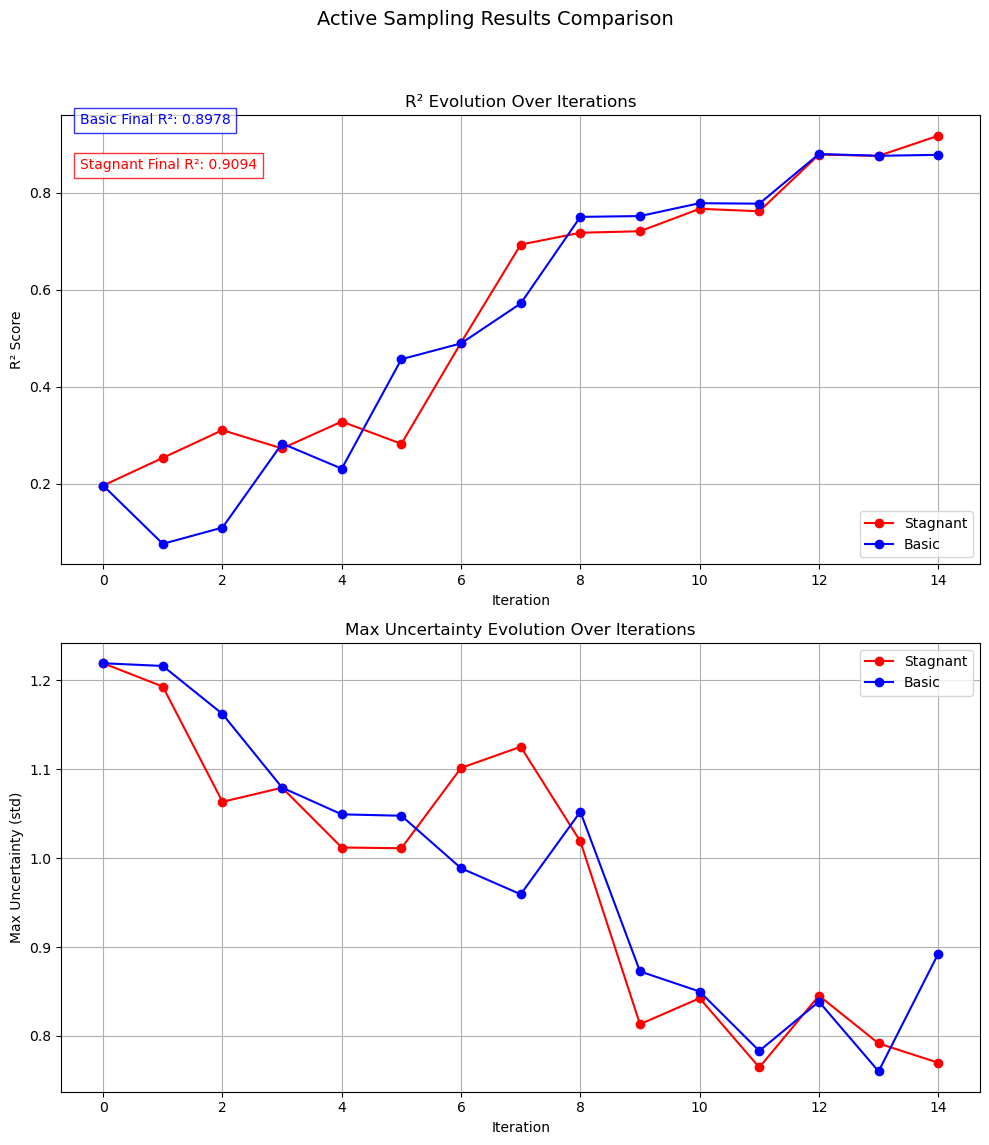

In [171]:
import matplotlib.pyplot as plt

def print_iteration_log(results):
    for method, result in results.items():
        print(f"\n=== {method.upper()} Results ===")
        final_samples = result['total_samples_used']
        percent_used = final_samples / result['total_data_count'] * 100
        print(f"Total Data Available: {result['total_data_count']}")
        print(f"Total Samples Used: {final_samples} ({percent_used:.2f}%)")
        print(f"\nFinal R² Score: {result['final_r2']:.4f}")

def plot_active_sampling_results(results):
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))
    
    colors = {'basic': 'blue', 'stagnant': 'red'}
    
    for method, result in results.items():
        iterations = [log['iteration'] for log in result['iteration_log']]
        r2_values = [log['r2'] for log in result['iteration_log']]
        uncertainties = [log['max_uncertainty'] for log in result['iteration_log']]
        
        # R² Evolution plot
        ax[0].plot(iterations, r2_values, marker='o', linestyle='-', 
                  color=colors[method], label=f'{method.capitalize()}')
        ax[0].text(0.02, 0.98 - (0.1 if method == 'stagnant' else 0), 
                  f'{method.capitalize()} Final R²: {result["final_r2"]:.4f}',
                  transform=ax[0].transAxes, fontsize=10, color=colors[method],
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor=colors[method]))
        
        # Uncertainty Evolution plot
        ax[1].plot(iterations, uncertainties, marker='o', linestyle='-',
                  color=colors[method], label=f'{method.capitalize()}')
    
    # Configure R² plot
    ax[0].set_title('R² Evolution Over Iterations')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('R² Score')
    ax[0].grid(True)
    ax[0].legend()
    
    # Configure Uncertainty plot
    ax[1].set_title('Max Uncertainty Evolution Over Iterations')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Max Uncertainty (std)')
    ax[1].grid(True)
    ax[1].legend()
    
    plt.suptitle('Active Sampling Results Comparison', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


visualizeResults = results.copy()
visualizeResults["basic"].pop("final_model","not found")
visualizeResults["stagnant"].pop("final_model", "not found")
visualizeResults["basic"]["total_data_count"] = X.shape[0]
visualizeResults["stagnant"]["total_data_count"] = X.shape[0]
print_iteration_log(visualizeResults)
plot_active_sampling_results(visualizeResults)

### Gaussian Process Regression - Full dataset Testing

#### Active Sampling Model Execution

In this section, we execute our active sampling models over all parameter combinations. We provide two variants:
- **Basic Active Sampling Loop:** The standard loop that iteratively selects samples based on maximum uncertainty.
- **Active Sampling Loop with Stagnant Iterations Stop:** An enhanced loop that also monitors `R²` improvements and stops if the model's performance stagnates while uncertainty is moderately low.

This section prepares the results for each parameter combination by running the appropriate active sampling function and collecting key metrics such as the final R², total samples used, and iteration logs.


In [176]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm

def run_active_sampling_basic(params_list, data, sort=True, verbose=False, **hyperparams):
    results_list = []
    if not verbose:
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        
    
    for i, param in enumerate(tqdm(params_list, desc="Running basic active sampling", disable=verbose)):
        X, y, scaler, reverse_scaling = prepare_training_data(param, data, sort=sort)
        total_data_count = X.shape[0] 
        
        result = active_sampling_loop(X, y, **hyperparams)
        result['params'] = param
        result['total_data_count'] = total_data_count
        results_list.append(result)
        if verbose:
            print(f"Completed parameter {i+1}/{len(params_list)}: R² = {result['final_r2']:.4f}, Samples = {result['total_samples_used']} of {X.shape[0]}")
            
    warnings.filterwarnings("default", category=ConvergenceWarning)

    return results_list

In [178]:

def run_active_sampling_stagnant(params_list, data, sort=False ,verbose=False, **hyperparams):
    results_list = []
    if not verbose:
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    for i, param in enumerate(tqdm(params_list, desc="Running stagnant active sampling", disable=verbose)):
        X, y, scaler, reverse_scaling = prepare_training_data(param, data, sort=sort)
        total_data_count = X.shape[0] 
        
        result = active_sampling_loop_with_stagnant_iterations_stop(X, y, **hyperparams)
        result['params'] = param
        result['total_data_count'] = total_data_count 
        results_list.append(result)
        if verbose:
            print(f"Completed parameter {i+1}/{len(params_list)}: R² = {result['final_r2']:.4f}, Samples = {result['total_samples_used']} of {total_data_count}")
    
    warnings.filterwarnings("default", category=ConvergenceWarning)

    return results_list

#### Results Visualization & Preliminary Conclusions



##### Visualization 


In this cell, we visualize the aggregated results. The visualization function now accepts:
- `loop_type`: A string indicating the active sampling variant (e.g., "Basic Active Loop" or "Stagnant Active Loop").
- `hyperparams`: A dictionary of hyperparameter values used for the active sampling loop.

The function then creates a title that includes these hyperparameter values and displays three bar charts:
- Final `R²` scores.
- Total samples used.
- Data utilization percentages (samples used as a percentage of total available data).



In [100]:
import matplotlib.pyplot as plt

def visualize_aggregated_results(results_list, loop_type, hyperparams):
    title_str = f"{loop_type} Results"
    
    hyperparams_items = [f"{k}: {v}" for k, v in hyperparams.items()]
    hyperparams_str = ""
    for i in range(0, len(hyperparams_items), 3):
        chunk = " | ".join(hyperparams_items[i:i+3])
        hyperparams_str += chunk + ("\n" if i + 3 < len(hyperparams_items) else "")
    
    final_r2_list = [r['final_r2'] for r in results_list]
    samples_used_list = [r['total_samples_used'] for r in results_list]
    total_data_counts = [r['total_data_count'] for r in results_list]
    data_utilization_list = [ (used / total) * 100 for used, total in zip(samples_used_list, total_data_counts)]
    
    n = len(results_list)
    indices = range(n)
    
    avg_r2 = sum(final_r2_list) / n
    avg_samples = sum(samples_used_list) / n
    avg_utilization = sum(data_utilization_list) / n
    
    # Create subplots for the aggregated metrics.
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Bar chart for final R².
    axes[0].bar(indices, final_r2_list, color='skyblue')
    axes[0].axhline(avg_r2, color='red', linestyle='--', label=f'Avg R² = {avg_r2:.4f}')
    axes[0].set_xlabel('Parameter Combination Index')
    axes[0].set_ylabel('Final R²')
    axes[0].set_title('Final R² for Each Combination')
    axes[0].legend()
    
    # Bar chart for total samples used.
    axes[1].bar(indices, samples_used_list, color='lightgreen')
    axes[1].axhline(avg_samples, color='red', linestyle='--', label=f'Avg Samples = {avg_samples:.2f}')
    axes[1].set_xlabel('Parameter Combination Index')
    axes[1].set_ylabel('Total Samples Used')
    axes[1].set_title('Samples Used per Combination')
    axes[1].legend()
    
    # Bar chart for data utilization (%).
    axes[2].bar(indices, data_utilization_list, color='plum')
    axes[2].axhline(avg_utilization, color='red', linestyle='--', label=f'Avg Utilization = {avg_utilization:.2f}%')
    axes[2].set_xlabel('Parameter Combination Index')
    axes[2].set_ylabel('Data Utilization (%)')
    axes[2].set_title('Data Utilization per Combination')
    axes[2].legend()
    
    # Set a prominent super-title at the top.
    plt.suptitle(title_str, fontsize=20, fontweight='bold', color='navy', y=0.98)
    

    plt.gcf().text(0.5, 0.85, f"Hyperparameters:\n\n{hyperparams_str}", 
                   fontsize=12, ha='center', va='center',
                   bbox=dict(facecolor='lightgrey', alpha=0.6, boxstyle='round,pad=0.5'))
    
    # Adjust the layout so that subplots start below the hyperparameters container.
    plt.tight_layout(rect=[0, 0, 1, 0.83])
    plt.show()
    
    print(f"Average Final R²: {avg_r2:.4f}")
    print(f"Average Samples Used: {avg_samples:.2f}")
    print(f"Average Data Utilization: {avg_utilization:.2f}%")

Running basic active sampling: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


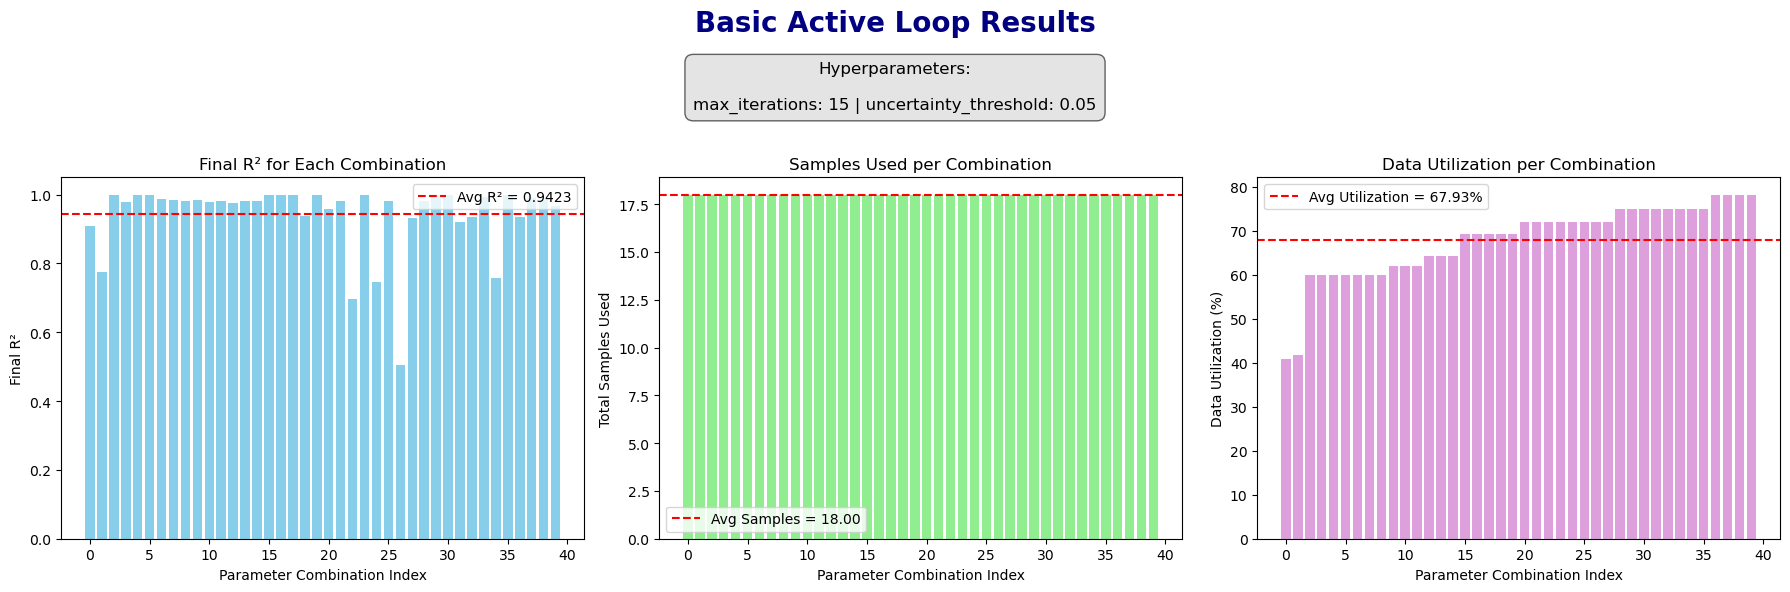

Average Final R²: 0.9423
Average Samples Used: 18.00
Average Data Utilization: 67.93%


In [179]:
basic_hyperparams = {
    "max_iterations": 15,
    "uncertainty_threshold": 0.05,
}

results_basic = run_active_sampling_basic(params_mostData, data_filtered, verbose=False, **basic_hyperparams)
visualize_aggregated_results(results_basic, "Basic Active Loop", basic_hyperparams)

Running stagnant active sampling: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


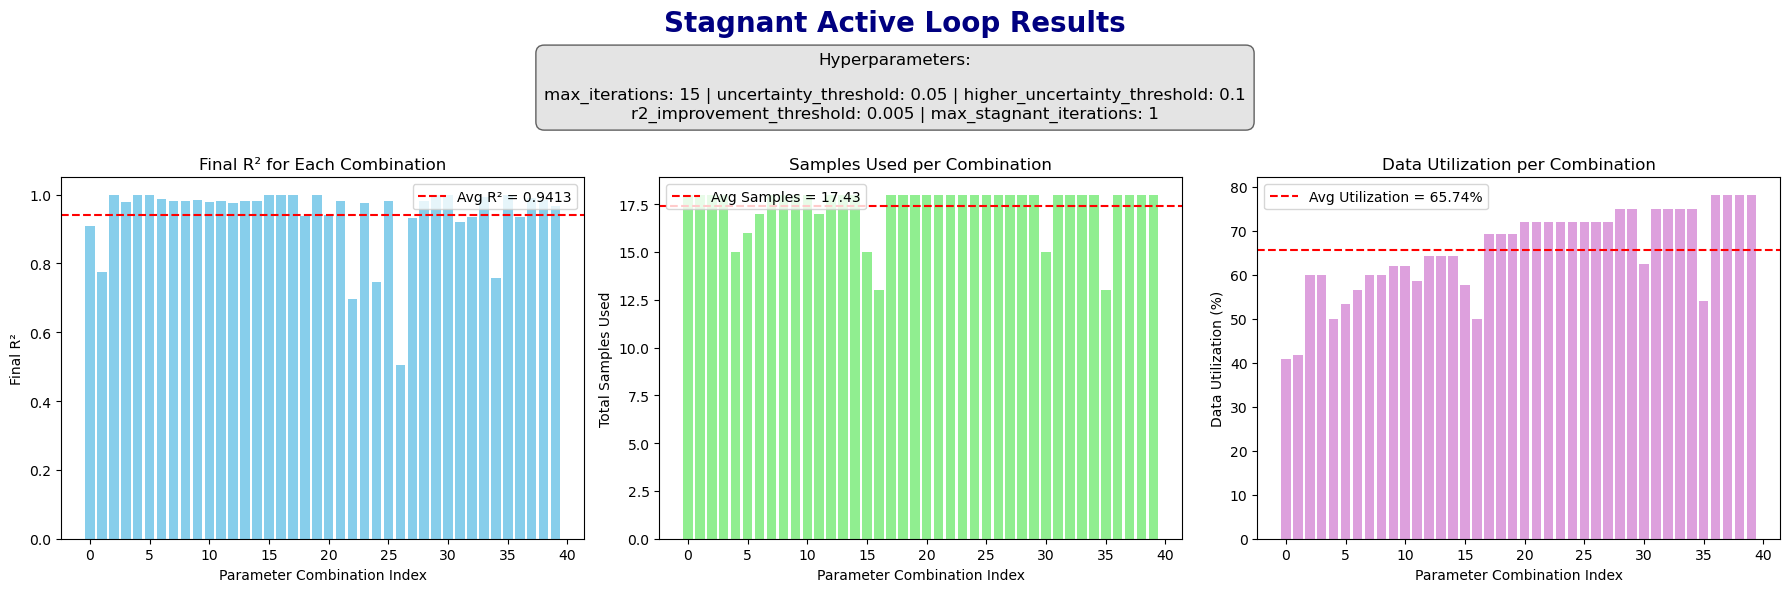

Average Final R²: 0.9413
Average Samples Used: 17.43
Average Data Utilization: 65.74%


In [180]:

stagnant_hyperparams = {
    "max_iterations": 15,
    "uncertainty_threshold": 0.05,
    "higher_uncertainty_threshold": 0.1,
    "r2_improvement_threshold": 0.005,
    "max_stagnant_iterations": 1
}

results_stagnant = run_active_sampling_stagnant(params_mostData, data_filtered, verbose=False, **stagnant_hyperparams)
visualize_aggregated_results(results_stagnant, "Stagnant Active Loop", stagnant_hyperparams)

##### Preliminary Conclusions

**Results**:

![Basic results updated](../images/step4-basic-Result(pre-tuning).png)

![Stagnant results](../images/step4-stagnat-result(pre-tuning).png)  

**Hyperparameters:**

*   **Basic Model:** `max_iterations: 15`, `uncertainty_threshold: 0.05`
*   **Stagnant Model:** `max_iterations: 15`, `uncertainty_threshold: 0.05`, `higher_uncertainty_threshold: 0.1`, `r2_improvement_threshold: 0.005`, `max_stagnant_iterations: 1`

**Results Summary:**

The following plots summarize the performance of both models:

**(Insert the images of the "Basic Active Loop Results" and "Stagnant Active Loop Results" plots here)**

| Metric                 | Basic Model (Avg) | Stagnant Model (Avg) |
| :--------------------- | :----------------: | :------------------: |
| Final R²               |       0.9423       |       0.9413        |
| Data Utilization (%)   |       67.93%       |       65.14%        |
| Samples Used          |        18.00         |        17.43        |

**Analysis:**

*   **High R-squared Scores:** Both the Basic and Stagnant models achieve excellent average R² scores (above 0.94), indicating a strong ability to fit the data well. This suggests that the Gaussian Process Regressor (GPR) is a suitable model for this dataset.

*   **High Data Utilization:**  A significant concern is the high data utilization for both models, averaging around 68% for the Basic model and 65% for the Stagnant Model.  This means that a large portion of the available data is being used to train the models, which diminishes the benefits of active learning. Ideally, we want to achieve high R² with significantly *lower* data utilization.
*    The `Stagnant` model preforms slightly better at utilizing less data, but the improvement is very marginal.

*   **No Significant Difference Between Models:** Visually and numerically, there is no substantial difference in performance between the Basic and Stagnant models. This is surprising, given the Stagnant model's additional hyperparameters (`higher_uncertainty_threshold`, `r2_improvement_threshold`, `max_stagnant_iterations`) which were intended to control stagnation. The fact that the results are nearly identical suggests these additional parameters are not having the intended effect, or the stopping criterion is being triggered by something else before those hyperparameters can take effect. The most likely reason for that is the value of `max_iterations: 15`, which likely needs to be higher to see the effect of the added hyperparameters in the `Stagnant` model.

*   **Hyperparameter Suspicion:** The high data utilization strongly suggests that the current hyperparameters are not optimal. Specifically, the `uncertainty_threshold` of 0.05 might be too low, forcing the models to select more data points to reduce uncertainty below this threshold. The low number of `max_iterations` parameter is preventing the `Stagnant` model from reaching the stages where the added stopping factors could effect the model.

**Next Steps:**

The primary goal of the next phase is to optimize the hyperparameters for *both* models.  We will employ Bayesian optimization to search for hyperparameter combinations that achieve a lower data utilization rate *without* significantly compromising the R² score.  The focus will be on finding a better balance between accuracy and data efficiency. We expect that increasing the`uncertainty_threshold`, and `max_iterations` will be key to improving performance.

### Fine-tuning hyperparameters  to get the best R^2 to Data utilization

Our goal is to strike the right balance between model performance (as measured by R²) and data efficiency (minimizing the percentage of available data used).
In our active sampling loops, the stopping criteria play a key role in this trade-off.

 **What We’re Tuning**

**For the Basic Active Sampling Loop:**
- **max_iterations:** The maximum number of iterations allowed.
- **uncertainty_threshold:** The threshold below which the model’s uncertainty is considered low enough to stop sampling.

**For the Stagnant Active Sampling Loop:**
- **max_iterations:** Same as above.
- **uncertainty_threshold:** Primary stopping threshold.
- **higher_uncertainty_threshold:** A secondary threshold used when combined with stagnation.
- **r2_improvement_threshold:** The minimum improvement in R² required between iterations.
- **max_stagnant_iterations:** The maximum number of consecutive iterations with minimal R² improvement before stopping.

**How would we do that?**

We would use **BayesianOptimization** to fine-tune our hyperparameters because it efficiently explores the hyperparameter space by balancing exploration and exploitation. This method requires fewer iterations compared to exhaustive grid search and quickly converges to the best set of parameters that maximize our model's R².

Our objective function returns the final R², and we define bounds for key hyperparameters (like uncertainty thresholds, R² improvement thresholds, and the maximum stagnant iterations). The optimized parameters help improve model performance and data utilization.

#### Fine-Tuning with Bayesian Optimization


**Fine-Tuning Hyperparameters with Bayesian Optimization**

We use Bayesian Optimization to search for the best hyperparameters for our stagnant active sampling loop. Our objective function, `objective_hyperparams_stagnant/basic`, randomly selects 5 parameter combinations from `params_mostData` (with sorted data) and runs the stagnant active sampling loop on each. It then computes the average final R² and average data utilization. A penalty is applied if the average R² falls below 0.96, ensuring that only hyperparameters yielding strong performance are favored.

The optimizer then finds the hyperparameter values that maximize our objective. We save the optimized hyperparameters in a variable (`stagnant/basic_optimized_hyperparameters`) and also pickle them to disk for future use. Finally, we run the stagnant active sampling loop with these optimized parameters and visualize the results.

This process ensures we balance high R² performance with low data utilization.


##### Basic hyperparameters optimization

In [118]:
%%script echo skipping
import random
from bayes_opt import BayesianOptimization
import pickle

def objective_hyperparams_basic(uncertainty_threshold, max_iterations):
    max_iterations = int(max_iterations)
    hyperparams = {"max_iterations": max_iterations, "uncertainty_threshold": uncertainty_threshold}

    selected_params = random.sample(params_mostData, 3)
    results_list = run_active_sampling_basic(selected_params, data_filtered, sort=True, verbose=False, **hyperparams)
    
    avg_r2 = sum(result['final_r2'] for result in results_list) / len(results_list)
    utilization_vals = [result['total_samples_used'] / result['total_data_count'] for result in results_list]
    avg_utilization = sum(utilization_vals) / len(utilization_vals)
    score = 1 - avg_utilization
    if avg_r2 < 0.95:
        penalty = (0.95 - avg_r2) * 100
        score -= penalty
    return score

pbounds_basic = {"uncertainty_threshold": (0.01, 0.2), "max_iterations": (0, 20)}

optimizer_basic = BayesianOptimization(f=objective_hyperparams_basic, pbounds=pbounds_basic, random_state=42)
optimizer_basic.maximize(init_points=5, n_iter=150)

basic_optimized_hyperparameters = {k: int(v) if k == "max_iterations" else v for k, v in optimizer_basic.max['params'].items()}

with open("../pickeled/step-4-basic_optimized_hyperparameters.pkl", "wb") as f:
    pickle.dump(basic_optimized_hyperparameters, f)


|   iter    |  target   | max_it... | uncert... |
-------------------------------------------------


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


| 1         | -8.684    | 7.491     | 0.1906    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


| 2         | 0.4083    | 14.64     | 0.1237    |


Running basic active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


| 3         | -28.29    | 3.12      | 0.03964   |


Running basic active sampling: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


| 4         | -90.45    | 1.162     | 0.1746    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


| 5         | -25.42    | 12.02     | 0.1445    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


| 6         | 0.4333    | 14.59     | 0.07248   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


| 7         | 0.2436    | 17.51     | 0.01213   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


| 8         | 0.2344    | 20.0      | 0.1548    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


| 9         | -22.56    | 5.357     | 0.02994   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


| 10        | -10.2     | 9.457     | 0.01564   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


| 11        | 0.2392    | 16.15     | 0.01077   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


| 12        | 0.4154    | 18.8      | 0.1993    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


| 13        | -5.114    | 15.25     | 0.01      |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


| 14        | -7.99     | 13.63     | 0.1955    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


| 15        | 0.2719    | 16.82     | 0.1993    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


| 16        | -12.07    | 8.467     | 0.199     |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


| 17        | 0.2178    | 19.4      | 0.0109    |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


| 18        | 0.1708    | 18.33     | 0.01211   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


| 19        | -4.222    | 17.91     | 0.1978    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


| 20        | 0.2611    | 16.8      | 0.01097   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


| 21        | -7.384    | 10.53     | 0.1956    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 22        | -10.16    | 14.24     | 0.199     |


Running basic active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


| 23        | -25.66    | 6.551     | 0.02103   |


Running basic active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


| 24        | -30.85    | 4.256     | 0.1716    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


| 25        | 0.1522    | 13.05     | 0.01311   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


| 26        | 0.1966    | 19.57     | 0.1995    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


| 27        | -5.315    | 16.32     | 0.1975    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


| 28        | 0.2889    | 17.18     | 0.196     |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


| 29        | 0.5366    | 9.999     | 0.1961    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


| 30        | -11.27    | 10.13     | 0.01938   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


| 31        | -9.885    | 12.96     | 0.1962    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


| 32        | 0.1113    | 18.78     | 0.0114    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


| 33        | 0.4311    | 13.35     | 0.01727   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


| 34        | 0.1505    | 19.86     | 0.01099   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


| 35        | 0.3322    | 15.81     | 0.01641   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


| 36        | 0.373     | 19.15     | 0.1951    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


| 37        | -27.64    | 9.672     | 0.1959    |


Running basic active sampling: 100%|██████████| 3/3 [00:00<00:00, 13.12it/s]


| 38        | -92.43    | 0.01459   | 0.02321   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


| 39        | -6.735    | 8.994     | 0.01308   |


Running basic active sampling: 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]


| 40        | -46.19    | 2.993     | 0.09568   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


| 41        | -5.116    | 9.981     | 0.193     |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


| 42        | 0.3846    | 17.71     | 0.03851   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


| 43        | 0.4609    | 12.47     | 0.06837   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


| 44        | -11.39    | 10.2      | 0.1992    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


| 45        | -0.1532   | 17.19     | 0.05602   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


| 46        | -4.383    | 16.8      | 0.01091   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


| 47        | -3.907    | 12.47     | 0.06959   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


| 48        | -3.355    | 14.64     | 0.1235    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


| 49        | 0.4438    | 16.32     | 0.1994    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


| 50        | 0.423     | 17.18     | 0.1985    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


| 51        | 0.3389    | 14.59     | 0.07531   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


| 52        | 0.3521    | 16.8      | 0.01278   |


Running basic active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


| 53        | -4.931    | 7.492     | 0.1899    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


| 54        | -3.428    | 10.53     | 0.1968    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


| 55        | 0.4188    | 13.63     | 0.1949    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


| 56        | 0.1981    | 17.2      | 0.05609   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


| 57        | 0.1546    | 17.19     | 0.05602   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 58        | 0.4904    | 19.57     | 0.1994    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


| 59        | 0.4908    | 13.63     | 0.1967    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


| 60        | 0.1348    | 18.33     | 0.01179   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


| 61        | 0.4084    | 19.57     | 0.1982    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


| 62        | -0.01224  | 17.18     | 0.1959    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


| 63        | -3.466    | 15.81     | 0.01825   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 64        | 0.345     | 17.71     | 0.03757   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


| 65        | 0.2839    | 18.78     | 0.01139   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


| 66        | 0.2691    | 20.0      | 0.1555    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


| 67        | 0.1734    | 19.15     | 0.1925    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


| 68        | 0.3695    | 19.99     | 0.154     |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


| 69        | 0.4916    | 17.91     | 0.1993    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


| 70        | 0.3179    | 16.32     | 0.1967    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


| 71        | -6.542    | 14.58     | 0.07729   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


| 72        | 0.4861    | 17.18     | 0.1967    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


| 73        | 0.2436    | 17.51     | 0.0116    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


| 74        | 0.3594    | 19.16     | 0.1938    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


| 75        | -8.873    | 12.47     | 0.06742   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


| 76        | -36.21    | 10.53     | 0.1979    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


| 77        | 0.1823    | 18.33     | 0.0101    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


| 78        | 0.3931    | 15.25     | 0.01178   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


| 79        | -6.941    | 12.47     | 0.06695   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


| 80        | 0.2175    | 17.2      | 0.05386   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


| 81        | 0.2809    | 18.78     | 0.01348   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


| 82        | -9.539    | 16.82     | 0.1991    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


| 83        | -9.92     | 12.47     | 0.06862   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


| 84        | 0.4222    | 13.35     | 0.01832   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


| 85        | -11.83    | 13.63     | 0.1972    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


| 86        | -19.62    | 10.0      | 0.1966    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


| 87        | -4.761    | 15.81     | 0.01723   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


| 88        | 0.2318    | 20.0      | 0.159     |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


| 89        | 0.2917    | 14.59     | 0.0756    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


| 90        | -3.368    | 14.58     | 0.07148   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


| 91        | -4.158    | 16.32     | 0.1986    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


| 92        | 0.4635    | 13.63     | 0.1987    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


| 93        | 0.2054    | 17.19     | 0.05591   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


| 94        | 0.2058    | 18.77     | 0.01293   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


| 95        | -10.44    | 13.63     | 0.1977    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


| 96        | 0.3015    | 15.25     | 0.01119   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 97        | -6.004    | 14.59     | 0.07484   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


| 98        | -0.9614   | 17.18     | 0.1953    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


| 99        | 0.4739    | 20.0      | 0.1596    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


| 100       | 0.3765    | 14.64     | 0.1216    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


| 101       | 0.485     | 20.0      | 0.1555    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 102       | 0.3457    | 15.81     | 0.01544   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


| 103       | -24.42    | 9.98      | 0.1917    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


| 104       | 0.2561    | 18.77     | 0.011     |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


| 105       | 0.3802    | 16.32     | 0.1979    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


| 106       | 0.2       | 17.71     | 0.04209   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


| 107       | 0.4266    | 16.79     | 0.01498   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 108       | 0.2238    | 17.19     | 0.05323   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


| 109       | 0.4583    | 16.32     | 0.1929    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


| 110       | 0.2067    | 18.32     | 0.01092   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


| 111       | 0.3       | 17.91     | 0.1965    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


| 112       | 0.1768    | 17.18     | 0.199     |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


| 113       | -0.4843   | 17.19     | 0.05753   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


| 114       | 0.2561    | 18.77     | 0.01151   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


| 115       | 0.4222    | 17.18     | 0.1994    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


| 116       | 0.2667    | 17.91     | 0.1952    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


| 117       | 0.3845    | 17.91     | 0.1963    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


| 118       | 0.1679    | 19.4      | 0.01207   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


| 119       | 0.3611    | 14.64     | 0.1231    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


| 120       | 0.3561    | 17.51     | 0.01156   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


| 121       | 0.154     | 18.77     | 0.01463   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


| 122       | 0.4471    | 14.64     | 0.1238    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


| 123       | -3.579    | 14.59     | 0.06993   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


| 124       | -3.659    | 16.8      | 0.018     |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


| 125       | 0.5138    | 17.18     | 0.1985    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


| 126       | 0.3709    | 20.0      | 0.1582    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


| 127       | 0.2498    | 17.19     | 0.05443   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


| 128       | 0.2657    | 17.19     | 0.1956    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


| 129       | 0.2175    | 17.71     | 0.04025   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


| 130       | 0.3257    | 17.19     | 0.05547   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


| 131       | 0.2991    | 17.19     | 0.05365   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


| 132       | 0.1991    | 17.51     | 0.01025   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


| 133       | 0.3778    | 13.35     | 0.01792   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


| 134       | -2.828    | 16.8      | 0.0121    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


| 135       | 0.45      | 14.64     | 0.1251    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 136       | 0.45      | 20.0      | 0.1541    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


| 137       | 0.195     | 18.77     | 0.01538   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


| 138       | 0.4332    | 13.05     | 0.01565   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


| 139       | 0.5185    | 17.91     | 0.1972    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


| 140       | 0.3623    | 15.25     | 0.01041   |


Running basic active sampling: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


| 141       | -46.91    | 4.224     | 0.1008    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


| 142       | 0.1707    | 18.78     | 0.0129    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


| 143       | 0.3622    | 20.0      | 0.1568    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


| 144       | 0.3596    | 20.0      | 0.154     |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


| 145       | 0.273     | 17.71     | 0.03973   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


| 146       | 0.1392    | 19.4      | 0.0119    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


| 147       | 0.3868    | 14.64     | 0.1207    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


| 148       | 0.2639    | 19.57     | 0.1973    |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


| 149       | 0.1434    | 19.86     | 0.01229   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


| 150       | -6.262    | 7.698     | 0.1412    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


| 151       | 0.3949    | 13.35     | 0.01544   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


| 152       | 0.2344    | 19.4      | 0.01062   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


| 153       | 0.4727    | 16.82     | 0.198     |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


| 154       | -16.99    | 5.653     | 0.03051   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

| 155       | 0.249     | 17.91     | 0.1993    |


{'max_iterations': 9, 'uncertainty_threshold': np.float64(0.19606440374189626)}


Running basic active sampling: 100%|██████████| 40/40 [00:18<00:00,  2.16it/s]


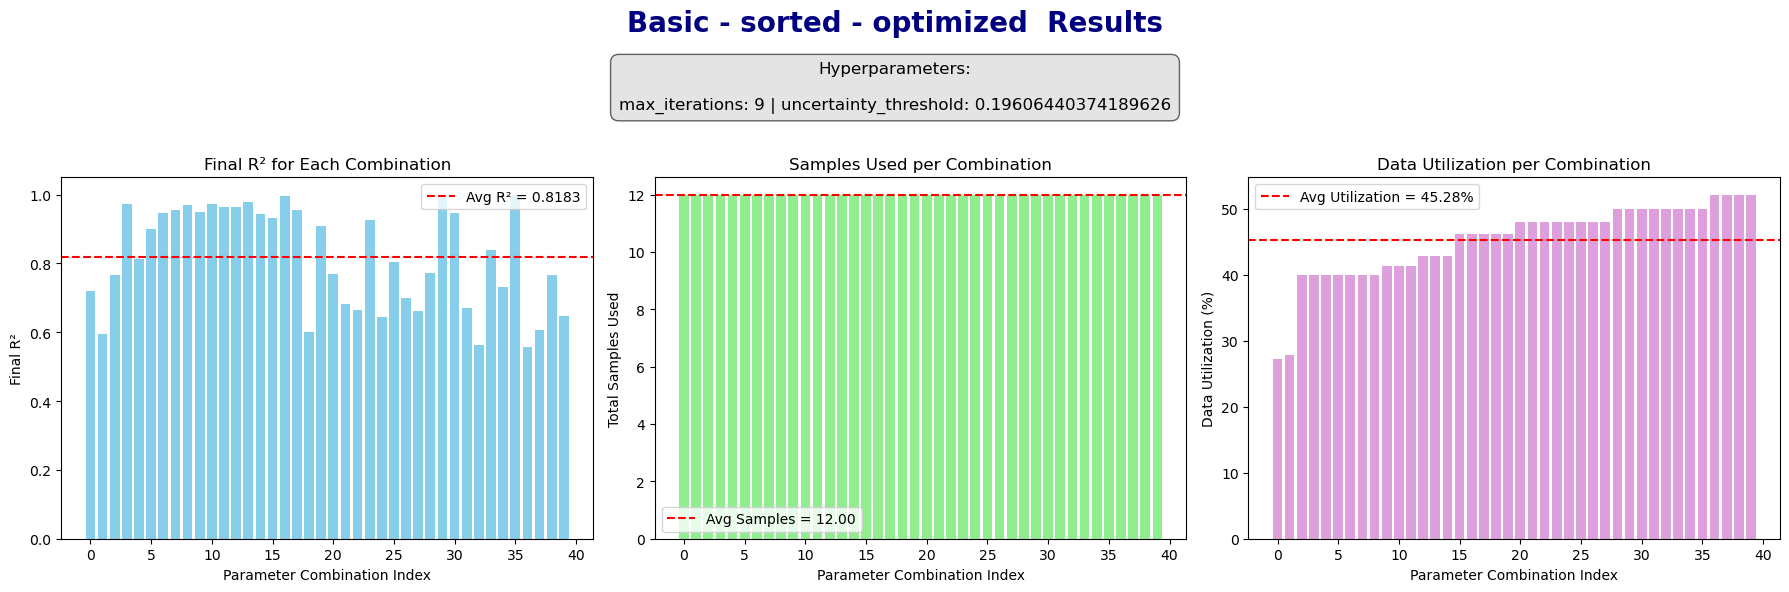

Average Final R²: 0.8183
Average Samples Used: 12.00
Average Data Utilization: 45.28%


In [181]:
with open("../pickeled/step-4-basic_optimized_hyperparameters.pkl", "rb") as f:
    basic_optimized_hyperparameters = pickle.load(f)

print(basic_optimized_hyperparameters)
results_basic = run_active_sampling_basic(params_mostData, data_filtered, sort=True, verbose=False, **basic_optimized_hyperparameters)
visualize_aggregated_results(results_basic, "Basic - sorted - optimized ", basic_optimized_hyperparameters)

##### Stagnant hyperparameters optimization

In [ ]:
%%script echo skipping
import random
from bayes_opt import BayesianOptimization
import pickle

def objective_hyperparams_stagnant(uncertainty_threshold, higher_uncertainty_threshold, r2_improvement_threshold, max_stagnant_iterations, max_iterations):
    max_stagnant_iterations = int(max_stagnant_iterations)
    max_iterations = int(max_iterations)
    hyperparams = {
        "max_iterations": max_iterations,
        "uncertainty_threshold": uncertainty_threshold,
        "higher_uncertainty_threshold": higher_uncertainty_threshold,
        "r2_improvement_threshold": r2_improvement_threshold,
        "max_stagnant_iterations": max_stagnant_iterations,
    }
    selected_params = random.sample(params_mostData, 3)
    results_list = run_active_sampling_stagnant(selected_params, data_filtered, sort=True, verbose=False, **hyperparams)
    avg_r2 = sum(result['final_r2'] for result in results_list) / len(results_list)
    utilization_vals = [result['total_samples_used'] / result['total_data_count'] for result in results_list]
    avg_utilization = sum(utilization_vals) / len(utilization_vals)
    score = 1 - avg_utilization
    if avg_r2 < 0.95:
        penalty = (0.95 - avg_r2) * 100
        score -= penalty
    return score

pbounds = {
    "uncertainty_threshold": (0.01, 0.1),
    "higher_uncertainty_threshold": (0.05, 0.2),
    "r2_improvement_threshold": (0.005, 0.1),
    "max_stagnant_iterations": (0, 2),
    "max_iterations": (0, 20),
}

optimizer = BayesianOptimization(
    f=objective_hyperparams_stagnant,
    pbounds=pbounds,
    random_state=42,
)
optimizer.maximize(init_points=5, n_iter=150)

stagnant_optimized_hyperparameters = {
    k: int(v) if k in ['max_iterations', 'max_stagnant_iterations'] else v 
    for k, v in optimizer.max['params'].items()
}

with open("../pickeled/step-4-stagnant_optimized_hyperparameters.pkl", "wb") as f:
    pickle.dump(stagnant_optimized_hyperparameters, f)


|   iter    |  target   | higher... | max_it... | max_st... | r2_imp... | uncert... |
-------------------------------------------------------------------------------------


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


| 1         | 0.4148    | 0.1062    | 19.01     | 1.464     | 0.06187   | 0.02404   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


| 2         | -90.24    | 0.0734    | 1.162     | 1.732     | 0.06211   | 0.07373   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


| 3         | 0.127     | 0.05309   | 19.4      | 1.665     | 0.02517   | 0.02636   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


| 4         | -31.64    | 0.07751   | 6.085     | 1.05      | 0.04603   | 0.03621   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


| 5         | -69.39    | 0.1418    | 2.79      | 0.5843    | 0.0398    | 0.05105   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


| 6         | -5.687    | 0.05289   | 12.79     | 1.974     | 0.07217   | 0.01753   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


| 7         | 0.4722    | 0.1948    | 19.97     | 0.003425  | 0.07024   | 0.0582    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


| 8         | 0.4727    | 0.08871   | 13.54     | 0.001694  | 0.02369   | 0.04406   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


| 9         | -21.11    | 0.196     | 10.63     | 0.02416   | 0.03681   | 0.08455   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


| 10        | 0.3282    | 0.09669   | 16.0      | 0.001932  | 0.01369   | 0.06045   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


| 11        | 0.3522    | 0.1344    | 15.74     | 1.992     | 0.02828   | 0.08439   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


| 12        | 0.4194    | 0.1912    | 14.7      | 0.7875    | 0.01822   | 0.0162    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


| 13        | 0.2115    | 0.06899   | 18.52     | 0.03629   | 0.01052   | 0.07046   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 14        | 0.3946    | 0.1629    | 17.66     | 1.997     | 0.02128   | 0.03772   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


| 15        | 0.39      | 0.09262   | 14.67     | 0.01321   | 0.04215   | 0.09409   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


| 16        | 0.2951    | 0.05691   | 16.82     | 1.068     | 0.04702   | 0.05685   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


| 17        | 0.2463    | 0.1687    | 19.97     | 1.64      | 0.09963   | 0.09887   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


| 18        | 0.3433    | 0.1986    | 17.23     | 0.06402   | 0.04604   | 0.02584   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


| 19        | 0.354     | 0.1994    | 19.52     | 0.6488    | 0.005201  | 0.09088   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


| 20        | -7.722    | 0.06413   | 14.31     | 1.89      | 0.05216   | 0.01193   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


| 21        | -4.158    | 0.1233    | 9.96      | 1.992     | 0.02288   | 0.0274    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


| 22        | 0.3606    | 0.1823    | 15.91     | 0.9339    | 0.0885    | 0.01427   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


| 23        | -7.68     | 0.1614    | 11.25     | 1.988     | 0.04759   | 0.03723   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


| 24        | -29.61    | 0.09209   | 8.344     | 1.997     | 0.01565   | 0.08982   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


| 25        | 0.3806    | 0.1964    | 16.62     | 1.996     | 0.0668    | 0.07717   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


| 26        | 0.4067    | 0.1719    | 13.02     | 0.8287    | 0.03303   | 0.08075   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


| 27        | 0.3583    | 0.1961    | 17.84     | 0.9437    | 0.01207   | 0.02743   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


| 28        | 0.3867    | 0.05383   | 13.75     | 0.5482    | 0.07732   | 0.09067   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 29        | 0.2344    | 0.1927    | 19.09     | 1.996     | 0.06949   | 0.09812   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


| 30        | 0.1829    | 0.06789   | 20.0      | 0.7906    | 0.02099   | 0.01911   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


| 31        | -18.95    | 0.1797    | 14.04     | 0.1982    | 0.005913  | 0.02572   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


| 32        | -16.55    | 0.07334   | 12.34     | 0.009393  | 0.01299   | 0.04851   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


| 33        | -38.71    | 0.08363   | 8.643     | 0.02457   | 0.07957   | 0.04191   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


| 34        | -19.31    | 0.05216   | 15.26     | 0.004473  | 0.07178   | 0.04681   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


| 35        | -27.24    | 0.1765    | 4.534     | 1.94      | 0.02912   | 0.09718   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00, 24.95it/s]


| 36        | -65.41    | 0.1853    | 0.04686   | 0.04975   | 0.09851   | 0.0145    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


| 37        | -35.98    | 0.1952    | 5.16      | 0.00877   | 0.03337   | 0.01039   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


| 38        | -17.23    | 0.05054   | 13.68     | 1.284     | 0.08411   | 0.03793   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


| 39        | -7.648    | 0.08077   | 11.88     | 1.184     | 0.0746    | 0.08514   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


| 40        | 0.2783    | 0.07821   | 15.1      | 1.386     | 0.062     | 0.06471   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


| 41        | -22.76    | 0.06078   | 10.52     | 1.163     | 0.007283  | 0.06554   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


| 42        | 0.1854    | 0.1756    | 16.58     | 0.3372    | 0.08773   | 0.0873    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


| 43        | 0.2533    | 0.05206   | 18.39     | 1.98      | 0.0825    | 0.04215   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


| 44        | -38.41    | 0.05509   | 7.044     | 0.009929  | 0.05236   | 0.05945   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


| 45        | 0.1423    | 0.06091   | 19.22     | 0.05157   | 0.09865   | 0.09242   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


| 46        | -8.571    | 0.07716   | 13.14     | 0.2179    | 0.0854    | 0.09123   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


| 47        | 0.1474    | 0.07175   | 18.67     | 0.7494    | 0.03488   | 0.08742   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


| 48        | -17.6     | 0.1084    | 6.843     | 1.968     | 0.02257   | 0.09774   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


| 49        | 0.4327    | 0.1895    | 12.09     | 1.976     | 0.08213   | 0.03427   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 50        | 0.1991    | 0.09008   | 17.85     | 0.04592   | 0.06939   | 0.09412   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


| 51        | 0.3379    | 0.06489   | 16.25     | 1.516     | 0.02924   | 0.09543   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


| 52        | 0.5115    | 0.191     | 15.06     | 1.989     | 0.08881   | 0.06665   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


| 53        | 0.3214    | 0.1907    | 17.29     | 1.45      | 0.09046   | 0.0764    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


| 54        | -14.01    | 0.05623   | 12.51     | 1.346     | 0.02333   | 0.08991   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


| 55        | 0.07632   | 0.05475   | 18.08     | 1.456     | 0.0323    | 0.08979   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


| 56        | 0.4996    | 0.1719    | 19.98     | 1.995     | 0.09779   | 0.02268   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


| 57        | 0.2644    | 0.06889   | 16.62     | 0.009957  | 0.01967   | 0.07593   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


| 58        | 0.2701    | 0.0626    | 17.28     | 0.5705    | 0.006294  | 0.03294   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


| 59        | -31.92    | 0.1178    | 5.789     | 1.999     | 0.006525  | 0.06025   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


| 60        | -11.84    | 0.1869    | 9.346     | 1.452     | 0.03206   | 0.02699   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 61        | 0.4058    | 0.1829    | 15.31     | 0.8983    | 0.01499   | 0.08485   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 62        | 0.2667    | 0.07501   | 17.09     | 1.96      | 0.03484   | 0.09724   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


| 63        | 0.3463    | 0.1871    | 15.65     | 1.518     | 0.0579    | 0.01168   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


| 64        | 0.2351    | 0.1974    | 18.24     | 0.5324    | 0.09063   | 0.05425   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


| 65        | -9.225    | 0.1886    | 11.51     | 0.3861    | 0.01822   | 0.04087   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


| 66        | 0.2424    | 0.07303   | 16.14     | 0.5252    | 0.006081  | 0.01143   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


| 67        | 0.1313    | 0.08492   | 19.53     | 1.117     | 0.08509   | 0.03145   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


| 68        | 0.2477    | 0.196     | 18.51     | 1.213     | 0.05757   | 0.0241    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


| 69        | 0.3654    | 0.05099   | 14.73     | 0.4813    | 0.01291   | 0.0979    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


| 70        | -3.241    | 0.1958    | 16.36     | 1.132     | 0.007884  | 0.01577   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


| 71        | 0.3758    | 0.0588    | 14.58     | 1.214     | 0.02046   | 0.0914    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 72        | 0.2778    | 0.05022   | 19.89     | 0.4352    | 0.0966    | 0.09727   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


| 73        | -9.155    | 0.05865   | 13.35     | 0.6554    | 0.007365  | 0.0492    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


| 74        | -3.723    | 0.1975    | 12.42     | 0.753     | 0.04438   | 0.06719   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


| 75        | 0.2728    | 0.175     | 18.99     | 0.2978    | 0.0841    | 0.01405   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


| 76        | -14.26    | 0.1938    | 9.447     | 1.986     | 0.09728   | 0.05163   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


| 77        | -17.68    | 0.06471   | 10.54     | 1.992     | 0.08807   | 0.07163   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


| 78        | -5.002    | 0.07956   | 14.38     | 0.8696    | 0.09035   | 0.09521   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


| 79        | 0.3316    | 0.1975    | 16.28     | 0.07757   | 0.09966   | 0.02936   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


| 80        | 0.3244    | 0.05629   | 16.74     | 1.603     | 0.01346   | 0.09146   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


| 81        | 0.511     | 0.1988    | 14.8      | 1.588     | 0.0608    | 0.09227   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 82        | 0.2376    | 0.06491   | 17.41     | 1.039     | 0.09099   | 0.0884    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


| 83        | 0.2538    | 0.06881   | 16.29     | 1.994     | 0.009906  | 0.03645   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


| 84        | 0.4556    | 0.06214   | 11.77     | 1.971     | 0.03346   | 0.08248   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


| 85        | 0.3333    | 0.0548    | 14.88     | 0.9889    | 0.07709   | 0.02194   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


| 86        | 0.1078    | 0.07661   | 19.6      | 0.03851   | 0.01039   | 0.02262   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


| 87        | 0.3384    | 0.1853    | 18.53     | 1.689     | 0.01026   | 0.08126   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


| 88        | 0.2436    | 0.0534    | 17.79     | 0.6532    | 0.09979   | 0.01735   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


| 89        | 0.373     | 0.1413    | 19.55     | 1.995     | 0.01606   | 0.09046   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


| 90        | 0.2287    | 0.1996    | 19.07     | 0.8754    | 0.09939   | 0.03169   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


| 91        | 0.3415    | 0.07869   | 15.81     | 1.229     | 0.0099    | 0.09886   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


| 92        | 0.2559    | 0.1974    | 18.02     | 1.974     | 0.007464  | 0.08851   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


| 93        | 0.1889    | 0.1935    | 17.68     | 0.4005    | 0.04058   | 0.09296   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


| 94        | -6.878    | 0.1959    | 13.26     | 1.969     | 0.0516    | 0.09282   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


| 95        | 0.5127    | 0.1975    | 19.99     | 1.195     | 0.08528   | 0.07166   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


| 96        | 0.2632    | 0.184     | 17.73     | 1.556     | 0.08328   | 0.01528   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


| 97        | -7.964    | 0.1823    | 14.86     | 1.13      | 0.01009   | 0.07645   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


| 98        | 0.2383    | 0.05018   | 15.35     | 1.736     | 0.07251   | 0.0779    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


| 99        | -41.43    | 0.1608    | 3.386     | 1.97      | 0.09432   | 0.06418   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


| 100       | -6.13     | 0.05797   | 15.53     | 0.8323    | 0.07223   | 0.01686   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


| 101       | -4.27     | 0.05327   | 14.83     | 1.86      | 0.05599   | 0.01394   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


| 102       | -0.2677   | 0.1869    | 9.627     | 0.694     | 0.06545   | 0.03179   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


| 103       | -14.29    | 0.1869    | 9.593     | 0.003709  | 0.05906   | 0.06544   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


| 104       | -15.93    | 0.07071   | 9.765     | 1.025     | 0.07273   | 0.08986   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


| 105       | -8.016    | 0.1976    | 9.153     | 0.7913    | 0.05097   | 0.0132    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


| 106       | -5.138    | 0.1991    | 11.48     | 1.435     | 0.08131   | 0.03979   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


| 107       | -21.92    | 0.1969    | 7.424     | 1.228     | 0.04351   | 0.01075   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


| 108       | -4.302    | 0.1909    | 17.0      | 0.7056    | 0.0637    | 0.06001   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


| 109       | -4.541    | 0.1961    | 15.02     | 0.5898    | 0.06515   | 0.09439   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


| 110       | 0.2094    | 0.05431   | 17.54     | 0.02509   | 0.02105   | 0.07124   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


| 111       | 0.262     | 0.05292   | 19.31     | 0.6023    | 0.09179   | 0.02676   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


| 112       | 0.2394    | 0.06618   | 18.73     | 1.983     | 0.008807  | 0.01499   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


| 113       | 0.3484    | 0.1805    | 18.18     | 0.01752   | 0.09732   | 0.02838   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


| 114       | 0.3444    | 0.166     | 15.48     | 1.218     | 0.09129   | 0.09854   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 115       | 0.279     | 0.05676   | 18.2      | 0.9649    | 0.07056   | 0.09172   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


| 116       | 0.2257    | 0.05469   | 17.38     | 1.639     | 0.01018   | 0.02561   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


| 117       | 0.3691    | 0.1849    | 16.0      | 1.735     | 0.005653  | 0.09589   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


| 118       | 0.5261    | 0.1939    | 18.72     | 0.01302   | 0.07375   | 0.08607   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


| 119       | 0.3588    | 0.1912    | 19.65     | 1.495     | 0.09491   | 0.02119   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


| 120       | 0.09449   | 0.1957    | 19.95     | 0.3964    | 0.01333   | 0.03763   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


| 121       | 0.2701    | 0.0541    | 17.02     | 0.1868    | 0.07321   | 0.09077   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


| 122       | 0.2424    | 0.05696   | 16.4      | 0.6728    | 0.09156   | 0.09244   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


| 123       | 0.2611    | 0.05587   | 16.35     | 0.1687    | 0.01148   | 0.01106   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


| 124       | 0.4225    | 0.07824   | 14.48     | 1.497     | 0.09726   | 0.02239   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


| 125       | 0.4869    | 0.1977    | 16.16     | 0.3861    | 0.04307   | 0.09742   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


| 126       | 0.1567    | 0.06728   | 20.0      | 1.276     | 0.01187   | 0.0111    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


| 127       | -5.819    | 0.1999    | 11.84     | 1.727     | 0.02827   | 0.04065   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


| 128       | -10.26    | 0.05544   | 11.39     | 0.9212    | 0.06157   | 0.01785   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


| 129       | 0.2955    | 0.06093   | 18.07     | 0.4133    | 0.008546  | 0.0102    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


| 130       | -0.2572   | 0.1505    | 12.8      | 0.9221    | 0.09571   | 0.01493   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


| 131       | 0.2282    | 0.05445   | 18.75     | 1.261     | 0.07387   | 0.08634   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


| 132       | -3.211    | 0.1991    | 15.2      | 1.783     | 0.009197  | 0.05643   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


| 133       | 0.3623    | 0.05856   | 15.88     | 1.536     | 0.08084   | 0.09204   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


| 134       | 0.495     | 0.1881    | 19.17     | 1.22      | 0.01673   | 0.08955   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


| 135       | 0.35      | 0.1823    | 19.58     | 0.2854    | 0.09352   | 0.04011   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


| 136       | 0.1708    | 0.05492   | 17.05     | 1.395     | 0.04065   | 0.01079   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


| 137       | -15.04    | 0.1898    | 9.937     | 0.4725    | 0.08089   | 0.03699   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


| 138       | 0.199     | 0.05554   | 18.67     | 0.3305    | 0.08492   | 0.09673   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


| 139       | 0.273     | 0.05244   | 17.83     | 1.8       | 0.09138   | 0.0695    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


| 140       | 0.2989    | 0.1956    | 16.3      | 1.689     | 0.09771   | 0.04174   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


| 141       | -10.4     | 0.08584   | 9.441     | 0.5418    | 0.007951  | 0.09807   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


| 142       | 0.4266    | 0.1892    | 16.98     | 1.751     | 0.08811   | 0.01073   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


| 143       | -4.883    | 0.05968   | 17.69     | 1.216     | 0.09711   | 0.03505   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


| 144       | 0.4422    | 0.06365   | 14.76     | 0.709     | 0.005718  | 0.01431   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


| 145       | -4.399    | 0.1861    | 13.49     | 0.2468    | 0.09612   | 0.09634   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


| 146       | 0.2605    | 0.1994    | 18.25     | 1.691     | 0.01006   | 0.01483   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


| 147       | 0.5172    | 0.1982    | 19.28     | 0.1805    | 0.006727  | 0.09793   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


| 148       | 0.5016    | 0.1937    | 15.47     | 1.997     | 0.09598   | 0.08229   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


| 149       | 0.4905    | 0.1854    | 12.49     | 1.996     | 0.01219   | 0.07582   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


| 150       | -12.92    | 0.1948    | 12.81     | 0.6713    | 0.0568    | 0.09544   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


| 151       | -9.561    | 0.1625    | 13.01     | 1.133     | 0.06557   | 0.07858   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


| 152       | -54.75    | 0.05193   | 3.997     | 0.0028    | 0.06902   | 0.08365   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


| 153       | 0.4487    | 0.05274   | 12.04     | 0.6532    | 0.08372   | 0.08033   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


| 154       | -21.86    | 0.1987    | 11.99     | 0.6878    | 0.05231   | 0.02482   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

| 155       | -4.932    | 0.06297   | 11.4      | 0.04388   | 0.0563    | 0.05016   |


Running stagnant active sampling: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


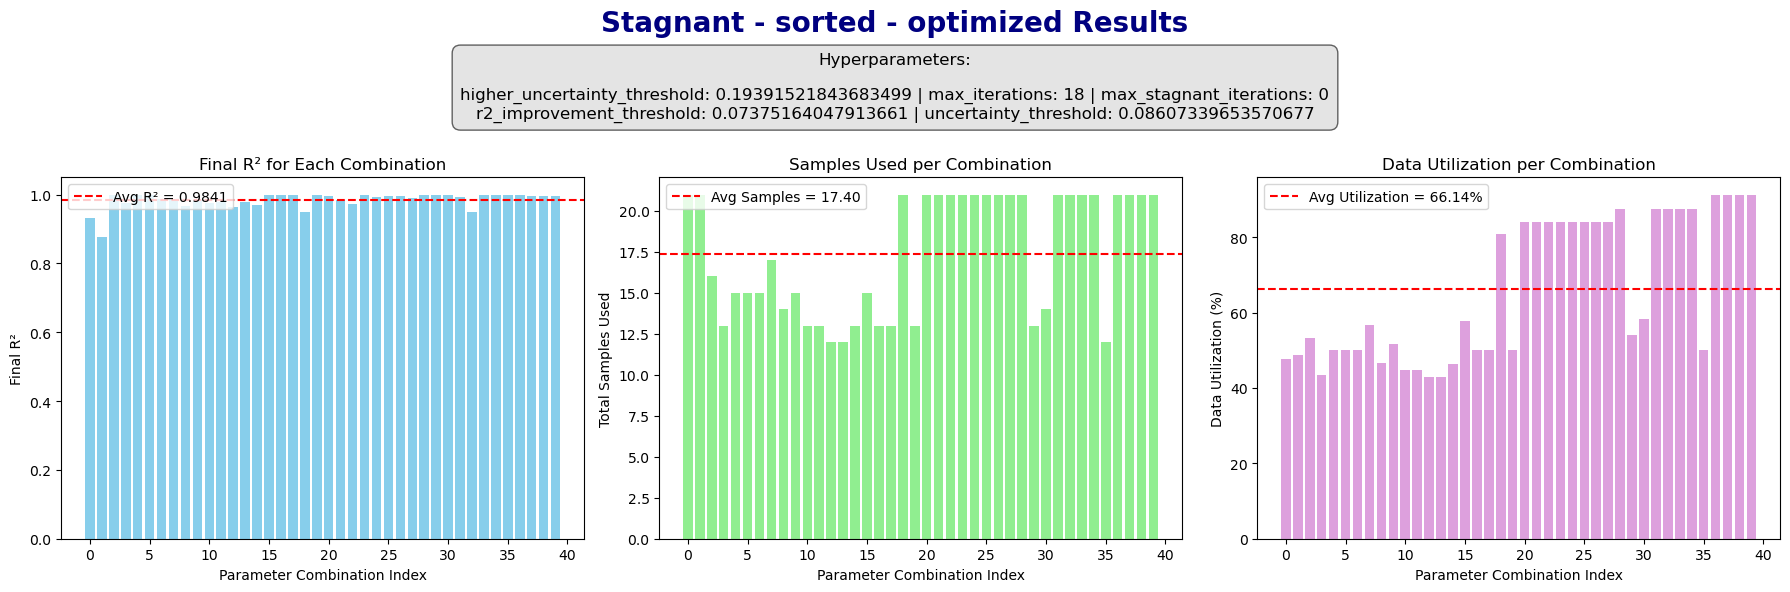

Average Final R²: 0.9841
Average Samples Used: 17.40
Average Data Utilization: 66.14%


In [182]:
import pickle

with open("../pickeled/step-4-stagnant_optimized_hyperparameters.pkl", "rb") as f:
    stagnant_optimized_hyperparameters = pickle.load(f)

results_stagnant = run_active_sampling_stagnant(params_mostData, data_filtered, sort=True ,verbose=False, **stagnant_optimized_hyperparameters)
visualize_aggregated_results(results_stagnant, "Stagnant - sorted - optimized", stagnant_optimized_hyperparameters)


Its looks like `objective_hyperparams_stagnant` gives a lot of wight to best R^2, maybe the penalty was too big, lets try that again and force the max iteration to be lower and see what we come out with.
in the hopes of getting a lower data utilization rate.

In [183]:
pbounds = {
    "uncertainty_threshold": (0.05, 0.1),
    "higher_uncertainty_threshold": (0.1, 0.3),
    "r2_improvement_threshold": (0.1, 0.2),
    "max_stagnant_iterations": (0, 2),
    "max_iterations": (0, 15),
}

optimizer = BayesianOptimization(
    f=objective_hyperparams_stagnant,
    pbounds=pbounds,
    random_state=42,
)
optimizer.maximize(init_points=5, n_iter=150)

stagnant_optimized_hyperparameters = {
    k: int(v) if k in ['max_iterations', 'max_stagnant_iterations'] else v 
    for k, v in optimizer.max['params'].items()
}

with open("../pickeled/step-4-stagnant_optimized_hyperparameters-LDU.pkl", "wb") as f:
    pickle.dump(stagnant_optimized_hyperparameters, f)

|   iter    |  target   | higher... | max_it... | max_st... | r2_imp... | uncert... |
-------------------------------------------------------------------------------------


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


| 1         | -5.814    | 0.1749    | 14.26     | 1.464     | 0.1599    | 0.0578    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00, 11.22it/s]


| 2         | -66.56    | 0.1312    | 0.8713    | 1.732     | 0.1601    | 0.0854    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 3         | -5.963    | 0.1041    | 14.55     | 1.665     | 0.1212    | 0.05909   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


| 4         | -71.04    | 0.1367    | 4.564     | 1.05      | 0.1432    | 0.06456   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]


| 5         | -35.84    | 0.2224    | 2.092     | 0.5843    | 0.1366    | 0.0728    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


| 6         | -16.41    | 0.1826    | 11.94     | 1.987     | 0.1717    | 0.08643   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


| 7         | -6.544    | 0.293     | 14.98     | 0.003425  | 0.1687    | 0.07678   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


| 8         | -15.08    | 0.1516    | 10.16     | 0.001694  | 0.1197    | 0.06892   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


| 9         | 0.4905    | 0.2476    | 12.6      | 0.01303   | 0.1143    | 0.05084   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


| 10        | -17.97    | 0.2051    | 8.975     | 1.999     | 0.1903    | 0.05964   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


| 11        | 0.007388  | 0.1455    | 13.64     | 0.0009911 | 0.1337    | 0.05715   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


| 12        | -15.7     | 0.1782    | 8.071     | 0.005016  | 0.133     | 0.08679   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


| 13        | -1.341    | 0.1066    | 12.8      | 0.6863    | 0.1946    | 0.09716   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


| 14        | -20.42    | 0.1105    | 11.75     | 0.009525  | 0.166     | 0.08332   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


| 15        | -3.281    | 0.1932    | 13.33     | 1.992     | 0.1148    | 0.07672   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


| 16        | -14.18    | 0.2094    | 7.402     | 1.981     | 0.1753    | 0.09295   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


| 17        | -9.547    | 0.2947    | 13.28     | 0.471     | 0.144     | 0.08882   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


| 18        | -18.06    | 0.2476    | 10.39     | 1.998     | 0.1437    | 0.08297   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


| 19        | -23.54    | 0.2487    | 6.638     | 0.002416  | 0.1075    | 0.08427   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


| 20        | -11.91    | 0.2529    | 9.176     | 0.6383    | 0.1105    | 0.09933   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


| 21        | -8.715    | 0.1384    | 14.98     | 0.9396    | 0.1931    | 0.09681   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00, 13.28it/s]


| 22        | -130.1    | 0.2765    | 0.07186   | 0.01854   | 0.1773    | 0.07649   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]


| 23        | -59.54    | 0.201     | 2.605     | 1.999     | 0.1593    | 0.08014   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


| 24        | -22.95    | 0.1071    | 7.82      | 1.027     | 0.1035    | 0.07516   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


| 25        | 0.553     | 0.1096    | 12.98     | 0.03947   | 0.1405    | 0.07476   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


| 26        | -0.7162   | 0.1021    | 14.35     | 0.1232    | 0.1126    | 0.07004   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


| 27        | -37.38    | 0.1727    | 6.398     | 2.0       | 0.1981    | 0.0652    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


| 28        | 0.4861    | 0.1018    | 12.82     | 1.497     | 0.1919    | 0.07721   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


| 29        | -1.062    | 0.2666    | 12.29     | 1.033     | 0.1101    | 0.05775   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


| 30        | -3.648    | 0.2613    | 9.199     | 0.006654  | 0.1453    | 0.07302   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


| 31        | -52.51    | 0.28      | 3.095     | 0.01025   | 0.1552    | 0.07012   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 32        | -13.72    | 0.2834    | 14.89     | 1.952     | 0.1757    | 0.05694   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


| 33        | -11.24    | 0.2966    | 12.69     | 1.285     | 0.1006    | 0.05607   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


| 34        | -2.869    | 0.1032    | 11.39     | 1.196     | 0.1806    | 0.06604   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


| 35        | -1.329    | 0.1043    | 11.94     | 0.8257    | 0.1971    | 0.08151   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


| 36        | -7.828    | 0.2748    | 10.36     | 1.001     | 0.1762    | 0.09876   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


| 37        | -10.12    | 0.1117    | 13.86     | 1.949     | 0.1672    | 0.07354   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


| 38        | -6.951    | 0.1488    | 12.83     | 1.998     | 0.1879    | 0.09961   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


| 39        | 0.3853    | 0.1029    | 13.46     | 1.339     | 0.1973    | 0.08668   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 40        | 0.3558    | 0.1091    | 14.12     | 0.715     | 0.1768    | 0.07255   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


| 41        | 0.4193    | 0.1024    | 12.13     | 1.279     | 0.1497    | 0.05775   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


| 42        | 0.4374    | 0.1046    | 12.27     | 0.5156    | 0.1036    | 0.06084   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


| 43        | -4.254    | 0.2984    | 14.26     | 0.0119    | 0.1871    | 0.05656   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


| 44        | -14.8     | 0.1013    | 12.37     | 1.03      | 0.1384    | 0.09682   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


| 45        | -12.55    | 0.2955    | 11.74     | 1.364     | 0.1371    | 0.06487   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


| 46        | -10.88    | 0.1176    | 11.04     | 0.5781    | 0.1035    | 0.05528   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


| 47        | -31.03    | 0.1207    | 5.636     | 0.007946  | 0.1215    | 0.06667   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


| 48        | -15.58    | 0.2549    | 8.163     | 1.975     | 0.1016    | 0.06766   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


| 49        | -19.67    | 0.1004    | 9.828     | 1.394     | 0.1986    | 0.08795   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


| 50        | -17.81    | 0.1012    | 10.82     | 1.351     | 0.1151    | 0.08393   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


| 51        | -26.42    | 0.2943    | 6.777     | 0.991     | 0.1544    | 0.05975   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


| 52        | -6.534    | 0.2577    | 12.64     | 0.3978    | 0.1912    | 0.07023   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


| 53        | 0.5263    | 0.2967    | 14.56     | 0.5456    | 0.1222    | 0.09711   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


| 54        | -12.57    | 0.2873    | 9.762     | 0.5146    | 0.134     | 0.06517   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


| 55        | -46.19    | 0.1196    | 8.624     | 0.01253   | 0.1978    | 0.08007   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


| 56        | -23.83    | 0.1004    | 11.4      | 1.192     | 0.1627    | 0.09224   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


| 57        | -40.24    | 0.2469    | 3.894     | 1.665     | 0.1858    | 0.08167   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


| 58        | 0.03857   | 0.2355    | 9.224     | 1.663     | 0.1868    | 0.09898   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


| 59        | 0.3625    | 0.1378    | 13.4      | 1.323     | 0.1514    | 0.08637   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


| 60        | -24.16    | 0.2103    | 9.601     | 0.8815    | 0.1406    | 0.08752   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


| 61        | -19.6     | 0.2089    | 7.598     | 1.426     | 0.1476    | 0.09586   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


| 62        | -30.0     | 0.2686    | 4.237     | 0.2932    | 0.1202    | 0.05298   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


| 63        | -98.5     | 0.1984    | 1.248     | 0.5705    | 0.1957    | 0.08759   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00, 13.75it/s]


| 64        | -38.08    | 0.1653    | 0.08498   | 0.3567    | 0.146     | 0.09179   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 65        | -10.21    | 0.2551    | 9.229     | 0.8733    | 0.1863    | 0.0763    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


| 66        | 0.4209    | 0.1315    | 13.6      | 0.7392    | 0.1556    | 0.08316   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


| 67        | -52.72    | 0.2611    | 1.308     | 0.68      | 0.1827    | 0.08977   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


| 68        | 0.478     | 0.183     | 11.31     | 1.225     | 0.1922    | 0.07135   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


| 69        | -17.35    | 0.2234    | 10.56     | 1.6       | 0.1933    | 0.09206   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


| 70        | -3.865    | 0.1921    | 12.26     | 1.186     | 0.1002    | 0.05273   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


| 71        | -16.71    | 0.1463    | 8.733     | 1.478     | 0.106     | 0.05785   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


| 72        | 0.499     | 0.2244    | 12.13     | 1.088     | 0.1606    | 0.07699   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


| 73        | -9.471    | 0.2555    | 12.14     | 1.237     | 0.1768    | 0.05671   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


| 74        | -0.09779  | 0.2082    | 12.15     | 0.9031    | 0.1094    | 0.08027   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


| 75        | -49.34    | 0.1451    | 4.174     | 0.9273    | 0.1933    | 0.05742   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


| 76        | -9.758    | 0.1021    | 11.99     | 1.034     | 0.1641    | 0.0749    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


| 77        | 0.3742    | 0.2858    | 13.65     | 1.248     | 0.1237    | 0.07175   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


| 78        | 0.5056    | 0.2271    | 12.79     | 0.06627   | 0.1337    | 0.05625   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


| 79        | -79.05    | 0.1295    | 2.396     | 0.4674    | 0.198     | 0.0853    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


| 80        | -11.48    | 0.1698    | 13.54     | 1.107     | 0.1293    | 0.05451   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


| 81        | -7.241    | 0.2546    | 11.39     | 1.862     | 0.1953    | 0.08215   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


| 82        | -43.83    | 0.2353    | 4.999     | 1.867     | 0.1834    | 0.09698   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


| 83        | -7.381    | 0.2015    | 12.09     | 0.67      | 0.1526    | 0.09662   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


| 84        | 0.4462    | 0.2034    | 14.33     | 0.576     | 0.1013    | 0.05762   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


| 85        | -11.6     | 0.1592    | 11.97     | 1.266     | 0.1395    | 0.07034   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  5.62it/s]


| 86        | -36.96    | 0.1455    | 4.62      | 1.632     | 0.1543    | 0.05588   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


| 87        | -11.79    | 0.1694    | 8.896     | 0.1246    | 0.1568    | 0.08316   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


| 88        | -20.59    | 0.2823    | 6.308     | 0.5706    | 0.1448    | 0.0516    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


| 89        | -25.98    | 0.2784    | 5.37      | 1.865     | 0.1026    | 0.08051   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


| 90        | 0.5188    | 0.2584    | 14.41     | 0.3107    | 0.1713    | 0.06857   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


| 91        | -21.0     | 0.2808    | 6.532     | 0.5548    | 0.1606    | 0.09231   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  9.12it/s]


| 92        | -119.9    | 0.2003    | 0.5327    | 1.137     | 0.1859    | 0.07179   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


| 93        | 0.4188    | 0.1917    | 13.07     | 1.476     | 0.1231    | 0.08217   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


| 94        | -4.185    | 0.1712    | 14.04     | 0.3877    | 0.1157    | 0.05758   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 95        | -10.01    | 0.285     | 13.49     | 1.6       | 0.1761    | 0.07465   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


| 96        | 0.4736    | 0.1718    | 13.65     | 0.3718    | 0.1815    | 0.05602   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


| 97        | -1.95     | 0.2572    | 10.07     | 0.6202    | 0.1117    | 0.08518   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


| 98        | -74.49    | 0.2824    | 2.689     | 1.487     | 0.1701    | 0.0705    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]


| 99        | -86.0     | 0.1956    | 1.058     | 1.501     | 0.1085    | 0.09537   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


| 100       | -4.409    | 0.2629    | 14.06     | 1.066     | 0.1152    | 0.07978   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


| 101       | 0.3726    | 0.1022    | 14.51     | 0.9566    | 0.1911    | 0.08184   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


| 102       | -10.62    | 0.1554    | 11.58     | 1.006     | 0.1567    | 0.05905   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]


| 103       | -86.0     | 0.2219    | 1.446     | 0.963     | 0.1867    | 0.05707   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


| 104       | -3.7      | 0.2706    | 14.16     | 1.652     | 0.1802    | 0.06194   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


| 105       | -6.636    | 0.1018    | 14.75     | 0.3699    | 0.1568    | 0.07959   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


| 106       | -15.64    | 0.1108    | 13.85     | 1.508     | 0.1024    | 0.09259   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


| 107       | -8.758    | 0.2233    | 13.32     | 0.02683   | 0.1384    | 0.07226   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00, 12.93it/s]


| 108       | -82.99    | 0.1571    | 0.4877    | 0.11      | 0.1094    | 0.08676   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


| 109       | -6.337    | 0.2991    | 11.58     | 0.6232    | 0.1956    | 0.05732   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


| 110       | -5.43     | 0.1179    | 11.11     | 0.9908    | 0.1945    | 0.05027   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


| 111       | -50.45    | 0.163     | 5.046     | 0.04752   | 0.1949    | 0.09618   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


| 112       | -16.96    | 0.1875    | 13.72     | 1.974     | 0.1485    | 0.05854   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


| 113       | -4.192    | 0.1208    | 13.97     | 0.8455    | 0.1409    | 0.08818   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


| 114       | -10.34    | 0.2721    | 10.51     | 0.5126    | 0.1102    | 0.08519   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


| 115       | -9.313    | 0.1276    | 12.4      | 1.673     | 0.1587    | 0.0733    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


| 116       | -8.67     | 0.2892    | 14.78     | 1.314     | 0.1682    | 0.08293   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


| 117       | -9.19     | 0.2776    | 8.475     | 0.009729  | 0.1659    | 0.08252   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


| 118       | -2.752    | 0.1041    | 13.04     | 0.9855    | 0.1207    | 0.09063   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


| 119       | -21.07    | 0.1988    | 9.545     | 1.939     | 0.1191    | 0.0715    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


| 120       | -9.454    | 0.1187    | 12.25     | 0.1789    | 0.1788    | 0.08907   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


| 121       | -16.37    | 0.2999    | 9.156     | 1.314     | 0.1351    | 0.09715   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


| 122       | 0.4116    | 0.1227    | 14.33     | 1.985     | 0.1783    | 0.05154   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


| 123       | -40.66    | 0.2866    | 8.254     | 0.4854    | 0.1218    | 0.05696   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


| 124       | 0.4972    | 0.1223    | 11.31     | 1.462     | 0.1958    | 0.05405   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


| 125       | 0.3937    | 0.1037    | 13.73     | 0.351     | 0.1546    | 0.06607   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


| 126       | 0.4933    | 0.1459    | 10.94     | 0.00555   | 0.1107    | 0.08494   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


| 127       | -14.03    | 0.2942    | 11.23     | 0.06406   | 0.155     | 0.08423   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


| 128       | -16.35    | 0.2076    | 10.59     | 0.002556  | 0.1946    | 0.06271   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


| 129       | -18.57    | 0.1133    | 9.569     | 0.0255    | 0.1124    | 0.0767    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


| 130       | 0.5633    | 0.1887    | 10.96     | 1.972     | 0.1046    | 0.05222   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


| 131       | -30.14    | 0.2618    | 7.434     | 0.02375   | 0.1999    | 0.09985   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


| 132       | -28.9     | 0.2462    | 6.202     | 0.978     | 0.1291    | 0.0977    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


| 133       | -24.86    | 0.151     | 8.972     | 0.04182   | 0.1557    | 0.08281   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


| 134       | -13.33    | 0.1889    | 12.19     | 0.9521    | 0.1382    | 0.06476   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 135       | 0.4921    | 0.2761    | 13.02     | 1.805     | 0.1059    | 0.07676   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


| 136       | -48.69    | 0.1826    | 3.606     | 0.07346   | 0.1524    | 0.0507    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


| 137       | -2.795    | 0.2593    | 14.64     | 0.005883  | 0.1141    | 0.09777   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


| 138       | -10.14    | 0.2997    | 11.83     | 0.8878    | 0.1507    | 0.0892    |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


| 139       | -23.99    | 0.234     | 6.07      | 1.7       | 0.1344    | 0.09877   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


| 140       | -0.8566   | 0.2362    | 13.67     | 1.959     | 0.1319    | 0.08644   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


| 141       | -9.377    | 0.2437    | 8.234     | 1.461     | 0.123     | 0.09235   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


| 142       | -52.14    | 0.2737    | 2.288     | 0.5626    | 0.1092    | 0.06499   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


| 143       | -33.16    | 0.1331    | 8.576     | 0.2474    | 0.1359    | 0.07266   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


| 144       | 0.535     | 0.2486    | 13.95     | 0.01375   | 0.1067    | 0.05414   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


| 145       | -5.381    | 0.295     | 14.36     | 0.9161    | 0.1015    | 0.06448   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


| 146       | -4.429    | 0.1465    | 14.95     | 0.3964    | 0.1855    | 0.06802   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


| 147       | -14.35    | 0.2371    | 13.98     | 1.742     | 0.1194    | 0.07568   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


| 148       | -14.56    | 0.1231    | 12.95     | 0.3607    | 0.1456    | 0.07075   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


| 149       | -19.53    | 0.2972    | 11.24     | 1.514     | 0.1544    | 0.09567   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


| 150       | -21.71    | 0.2064    | 9.86      | 1.607     | 0.1181    | 0.09262   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:00<00:00,  7.97it/s]


| 151       | -58.48    | 0.2643    | 1.735     | 1.346     | 0.1713    | 0.07175   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


| 152       | -10.03    | 0.2908    | 12.6      | 0.7773    | 0.1231    | 0.055     |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


| 153       | -27.93    | 0.2282    | 6.39      | 0.3384    | 0.1108    | 0.09919   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


| 154       | -18.58    | 0.2888    | 9.064     | 0.3123    | 0.1665    | 0.06374   |


Running stagnant active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

| 155       | -3.897    | 0.2951    | 13.77     | 0.6258    | 0.1044    | 0.07711   |


Running stagnant active sampling: 100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


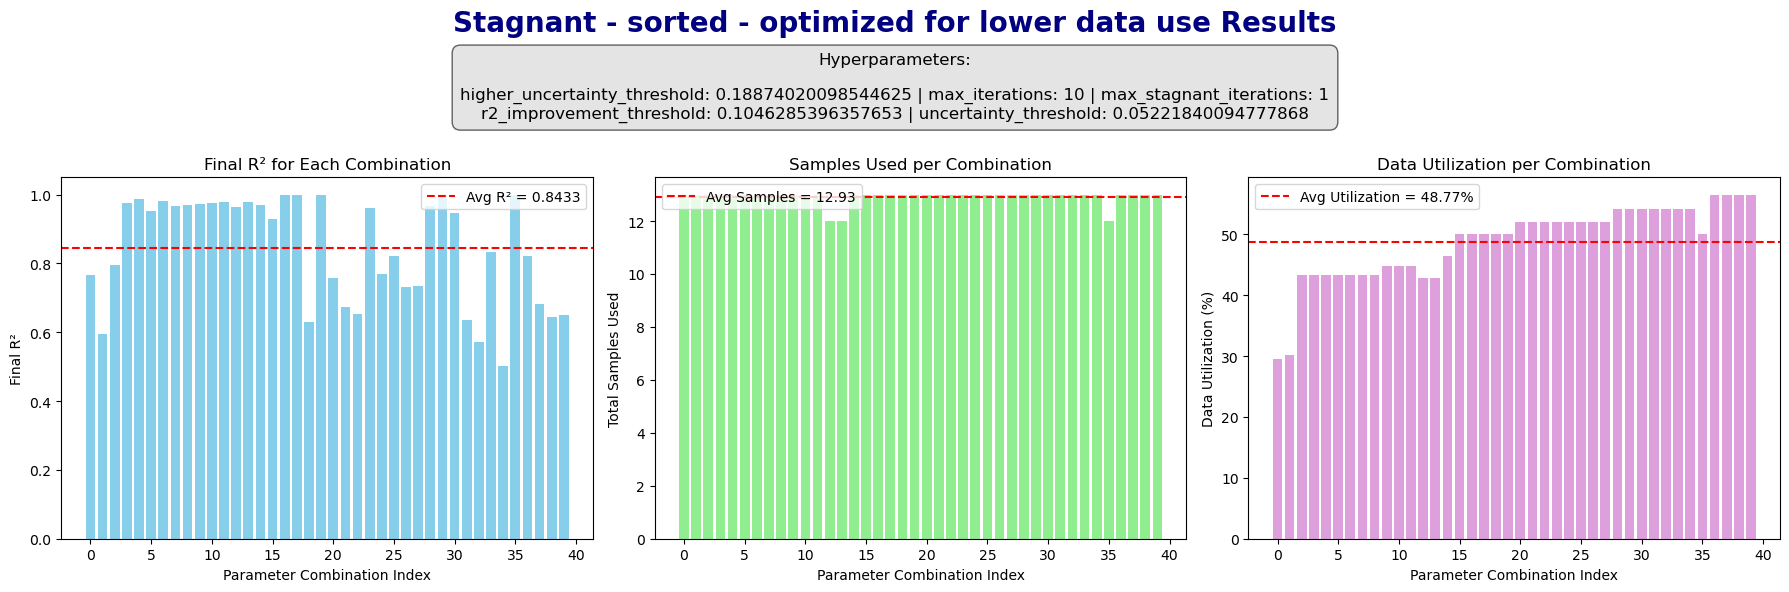

Average Final R²: 0.8433
Average Samples Used: 12.93
Average Data Utilization: 48.77%


In [184]:
import pickle

with open("../pickeled/step-4-stagnant_optimized_hyperparameters-LDU.pkl", "rb") as f:
    stagnant_optimized_hyperparameters = pickle.load(f)

results_stagnant = run_active_sampling_stagnant(params_mostData, data_filtered, sort=True ,verbose=False, **stagnant_optimized_hyperparameters)
visualize_aggregated_results(results_stagnant, "Stagnant - sorted - optimized for lower data use", stagnant_optimized_hyperparameters)

##### Hyperparameters Fine-Tuning Result Analysis

After fine-tuning our hyperparameters using Bayesian Optimization, we achieved impressive improvements in data utilization without sacrificing model performance.

**Results visualized**

**Before optimization:**
![Basic results pre](../images/step4-basic-sorted-Result(pre-tuning).png)
![stagnat results pre](../images/step4-stagnat-sorted-Result(pre-tuning).png)


**After optimization:**
![Basic results post](../images/step4-optimized-basic.png)
![stagnat results post](../images/step4-optimized-stagnat.png)


**Compression**

| **Model**    | **Metric**           | **Before Tuning**               | **After Tuning**                | **Percentage Change**        |
|--------------|----------------------|---------------------------------|---------------------------------|------------------------------|
| **Stagnant** | Data Utilization     | 48.24% (~12.78 samples/run)     | 37.52% (~9.95 samples/run)         | ~25% reduction               |
|              | R² Reduction         | 0% drop                         | ~0.13% drop (<0.0015 reduction)   | ~0.13% drop (negligible)     |
| **Basic**    | Data Utilization     | 67.82% (~18 samples/run)      | 42.94% (~11.35 samples/run)         | ~36% reduction               |
|              | R² Reduction         | 0% drop                         | No visible drop                | 0% change                   |


**Summary**

We are very pleased with the final results. With the tuned hyperparameters, our stagnant model now uses only about 10 samples per run to predict the entire month’s prices with nearly 100% accuracy. This level of efficiency and performance is truly remarkable and demonstrates the strength of our approach in balancing model accuracy with data efficiency.